# COGS 108 - Final Project

# Predicting Course Availability in First/Second Pass Enrollment at UCSD

# Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Names

- Chinmay Bharambe 
- Anshul Govindu 
- Chaela Moraleja 
- Candice Sanchez 
- Praveen Sharma

# Abstract

Our project aims to address a major challenge for UCSD students: deciding which classes to enroll in during first and second pass. We explored and analyzed UCSD enrollment data spanning 11 quarters (Fall 2022 through Winter 2025). We explored the relationship between course characteristics (department, specific course, fill rate, capacity, quarter season) and student factors (class standing/enrollment priority) to predict the number of open seats in undergraduate courses across departments. Our analysis revealed that enrollment priority significantly impacts seat availability, with higher-priority students consistently gaining better access to courses. Additionally, we found seasonal variations in enrollment patterns across quarters and identified departments with consistently higher fill rates. After conducting this in-depth EDA and analysis, we used a Random Forest Regression model to predict the number of open seats. We achieved an R² value of 0.949, demonstrating strong predictive power. This model can help students make more informed decisions about which courses to prioritize during different enrollment passes, potentially reducing registration stress and supporting timely graduation for students.

# Research Question

Using UCSD enrollment data since Fall 2022, what combination of course characteristics (fill rate, capacity, quarter) and student factors (class standing/units, which determines the enrollment start date), best predict the number of open seats, for undergraduate courses, across all departments, during first and second-pass registrations?

## Background and Prior Work

This project attempts to address a major challenge for UCSD students: deciding which classes to enroll in during first and second pass. UCSD’s unique “pass” enrollment system turns course selection into more of an art than a science, often leaving students uncertain about their choices or failing to enroll in certain classes. This process also involves other unusual factors, such as major priority for CSE courses. Overall, there is a definite need for a tool that maximizes students' chances of securing their desired courses.

Upon initial research, we came across a research paper on using Machine Learning Methods for Course Enrollment Prediction <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) at San Diego State University. Their primary focus was to predict course enrollment rates based on demographic and academic performance data. Although these variables are not an element of our research, their methodology with student data is applicable. For example, they considered generic variables like major and prerequisites, and incorporated predictive models like classification and regression trees. Therefore, we can build on this analysis with similar ML and statistical approaches that consider more course and student-specific factors, such as the ones mentioned in the research question.

We also found two projects directly related to UCSD enrollment. This project collects data on individual classes at different points in time during each term, such as Fall 2022 or Winter 2023; each term’s data is contained within its own repository <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). The project involved building a web scraping tool that scrapes web-reg about every 10 minutes and collects real-time data on information like enrolled, available, and waitlist spots. This not only offers a tool to collect our data in the future but also a great sample dataset from what has already been collected.

The second project was built using the aforementioned GitHub repositories  <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Given a course, the website takes data from specific terms and plots the course availability as a time series across various registration milestones (senior first pass, junior second pass, etc). This offers a great initial visualization of the enrollment data, and our EDA would likely produce some similar graphs. However, our objective is to quantify the relationship between student/course factors and course availability and use our analysis to develop a recommendation system that helps students prioritize courses for first and second pass. Additionally, we plan on conducting our research on data collected across 11 quarters as compared to only one quarter shown in the stated project. We believe this is significant because there may exist quarterly patterns for some classes that a single quarter would fail to grasp.


1. <a name="cite_note-1"></a> [^](#cite_ref-1) https://par.nsf.gov/servlets/purl/10389427 
2. <a name="cite_note-2"></a> [^](#cite_ref-2) https://github.com/UCSD-Historical-Enrollment-Data
3. <a name="cite_note-3"></a> [^](#cite_ref-3) https://www.ucsdregistration.com


# Hypothesis


We predict that a course’s fill rate and student class standing would be the most influential combination of factors for students deciding on courses to enroll in and directly influence the number of open seats remaining during first and second pass. More specifically, we predict that courses with a higher fill rate and later enrollment period (due to higher class standing) would mean there are fewer seats available, and thus more likely to reach full capacity during first pass rather than second pass.

# Setup

The code block below consists of all the libraries and packages we use in this project

In [1]:
import pandas as pd
import numpy as np

import os
import io
import requests
import time
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Data

## Dataset: UCSD Historical Enrollment Data

### Dataset Overview
  - Dataset Name: UCSD Historical Enrollment Data
  - Link to the dataset: https://github.com/UCSD-Historical-Enrollment-Data/UCSDHistEnrollData?tab=readme-ov-file
  - Number of observations: 11 quarters of data is recorded, the number of observations for subjects across the quarters is inconsistent.
  - Number of variables: There are 5 variables recorded: 
    - Time : The date and time the data was recorded
    - Enrolled : Number of students enrolled
    - Available : Number of seats available
    - Waitlisted : number of students waitlisted
    - Total : total seats available for the course 

This dataset was compiled using an automated web scraper that collected enrollment information from UC San Diego courses, spanning from Fall 2022 through to the current quarter (Winter 2025). The data is stored in CSV files that are hosted on GitHub.


### Dataset Structure and Organization

The UCSD Historical Enrollment Data is systematically organized within a GitHub repository, where each academic term is represented by a dedicated repository. This structure facilitates easy access to term-specific enrollment data. The data collection process is such that it captures enrollment statistics at regular intervals, providing a detailed view of how course enrollment evolves throughout the registration period.

The granularity of the data collection, which is approximately every 10 minutes during active enrollment periods, offers in depth insight into enrollment patterns, though for the purpose of our analysis, we will be implementing a more manageable sampling frequency. 

### Data Quality and Completeness

The dataset encompasses all undergraduate courses offered at UC San Diego across eleven quarters, providing a comprehensive view of enrollment patterns. While the number of observations varies between courses and quarters—primarily due to differences in course offerings and enrollment period durations — the consistency in variable recording ensures data compatibility across all terms.

### Data Processing Considerations
For our analysis, several key processing steps will be implemented:
1. Temporal aggregation to reduce unnecessary granularity while maintaining ensuring the trend of the data is captured accurately
2. Consistency of course codes to enable cross-quarter analysis
3. Enrollment phase demarcations (first pass, second pass, waitlist periods)
4. Creation of derived metrics such as fill rates to enhance analysis capabilities
5. Assignment of class standings (First-Year, Sophomore, Junior, Senior) to reflect enrollment priority hierarchies.

This dataset serves as an invaluable resource for understanding UC San Diego's enrollment patterns, offering insights that can inform both administrative decision-making and student course planning strategies.

### Collecting the Data

The initial approach to data collection from GitHub appeared straightforward, utilizing the pandas' read_csv() method to access the datasets hosted on GitHub. However, the extensive scope of the dataset—encompassing thousands of subjects with multiple observations across eleven academic quarters rendered this method inefficient, with projected data retrieval times exceeding twelve hours.

To enhance performance, we implemented several optimization strategies. First, we employed the chunking mechanism within read_csv() to process data in segments. While this modification yielded some improvement in processing speed, the enhancement was marginal for our requirements. Furthermore, we encountered limitations imposed by GitHub's API rate restrictions.<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). 

To address these constraints, we implemented parallel processing using the concurrent.futures package, enabling simultaneous retrieval of multiple files. This significantly improved operational efficiency<a name="cite_ref-1"></a><sup>1</sup>. Additionally, we found that GitHub's API authentication system offered substantially higher rate limits, 5,000 requests per hour, for authenticated users compared to 60 for unauthenticated users. Therefore we implementated authentication headers in our requests to effectively circumvent the restrictions.

A subsequent challenge emerged regarding data completeness. Our initial API implementation for retrieving directory contents was subject to GitHub's truncation limit of 999 files per directory, resulting in incomplete data collection. Through further research, we identified that the git/trees API provided access to the complete file directory, including previously truncated entries. This solution ensured we collected complete data<a name="cite_ref-2"></a><sup>2</sup>.

To optimize computational efficiency and eliminate redundant processing, we stored the collected data in enrollment_data.csv. The presence of this file in the working directory enables the system to skip the data collection process during subsequent notebook kernel restarts.

1. <a name="cite_note-1"></a> [^](#cite_ref-1) https://medium.com/@smrati.katiyar/introduction-to-concurrent-futures-in-python-009fe1d4592c
2. <a name="cite_note-2"></a> [^](#cite_ref-2) https://docs.github.com/en/rest/repos/contents?apiVersion=2022-11-28

In [2]:
# list of all the repo-links that host the data for each quarter in a csv file
repo_links = [
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2022Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Winter/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Spring/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2023Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Winter/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Spring/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer1/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer2/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Summer3/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2024Fall/contents/overall',
    'https://api.github.com/repos/UCSD-Historical-Enrollment-Data/2025Winter/contents/overall',
      ]

quarter_names = ['FA 22','WI 23', 'SP 23', 'FA 23', 'WI 24', 'SP 24', 'S1 24', 'S2 24', 'S3 24', 'FA 24', 'WI 25']

In [3]:
# github token for adressing the limit on github api rates. 
# recommended to create an environment varaible to store this for improved security. Alternatively, one can simply add the github token below
GITHUB_TOKEN = 'put in your token'  

In [4]:

# check if the new enrollment data file already exists
if os.path.exists('enrollment_data.csv'):
    df = pd.read_csv('enrollment_data.csv') 
else:
    # this function processes the data quarter by quarter
    def process_quarter(repo_link, quarter_name):
        # try-except block to handle errors
        try:
            # extract repo name from the API URL
            repo_name = repo_link.split('/')[5]  
            
            # construct tree API URL to gett all the files that are hidden as well
            tree_url = f"https://api.github.com/repos/UCSD-Historical-Enrollment-Data/{repo_name}/git/trees/main?recursive=1"
            
            # add headers to account for GitHub API rate limiting
            headers = {
                'Accept': 'application/vnd.github.v3+json',
                'Authorization': f'token {GITHUB_TOKEN}'
            }
            
            # get the tree
            response = requests.get(tree_url, headers=headers)
            
            # if request was unsuccessful print error message
            if response.status_code != 200:
                print(f"failed to access {tree_url}")
                print(f"Response: {response.text}")
                return None
                
            # get all files from the 'overall' directory
            all_files = [item['path'].split('/')[-1] 
                        for item in response.json()['tree'] 
                        if item['path'].startswith('overall/') and item['path'].endswith('.csv')]
                        
            # process multiple files in parallel to make the process faster and more efficient
            dfs = []
            with ThreadPoolExecutor(max_workers=5) as executor:
                # create a list of futures where each future represents a file being processed
                futures = [executor.submit(process_file, file, repo_name, quarter_name) 
                        for file in all_files]
                
                # loop through completed futures and collect results
                for future in futures:  
                    try:
                        df = future.result()
                        if df is not None:
                            dfs.append(df)
                    except Exception as e:
                        # print error in case of an error
                        print(f"error in future: {str(e)}")
            
            # if dfs is not empty, concatenate all the dfs for that quarter and return that
            if dfs:
                return pd.concat(dfs, ignore_index=True)
            return None
            
        except Exception as e:
            # print error msg if it occurs
            print(f"error processing quarter {quarter_name}: {str(e)}")
            return None

    # function that reads the csv file and makes it into a df
    def process_file(file, repo_name, quarter_name):
        print(file)
        # try-except block to handle errors
        try:
            # convert file name to the format seen in the url
            file_url = file.replace(' ','%20')
            
            # raw csv file link
            raw_url = f"https://raw.githubusercontent.com/UCSD-Historical-Enrollment-Data/{repo_name}/main/overall/{file_url}"
            
            # add authentication headers
            headers = {
                'Accept': 'application/vnd.github.v3+json',
                'Authorization': f'token {GITHUB_TOKEN}'
            }
            
            # Read the csv files with authentication
            response = requests.get(raw_url, headers=headers)
            response.raise_for_status()
            
            # read csv file into a pandas df
            df = pd.read_csv(
                io.StringIO(response.text),
                sep=',',              # the separator
                encoding='utf-8',     # specify the character encoding
                parse_dates=['time'], # parse dates as datetime objects as they are being read to save time
                usecols=['time', 'enrolled', 'available', 'waitlisted', 'total'] # specify column names to improve efficiency
            )
            
            if not df.empty:
                # add course column that is readable
                df['course'] = file.replace('.csv', '').replace('%20',' ')
                # group df at a frequency of every 12 hrs to get 2 readings for each day
                df = df.groupby(pd.Grouper(key='time', freq='12h')).first().reset_index()
                # add a column that stores the quarter name
                df['quarter'] = quarter_name
                return df
            return None
            
        except Exception as e:
            # if there is an error, print it
            print(f"error processing {file}: {str(e)}")
            return None

    def load_data():
        # list that will store the df for every quarter
        all_quarter_dfs = []

        # loop through each quarter and process its data
        for repo_link, quarter_name in zip(repo_links, quarter_names):  
            # delay to avoid hitting githubs rate limits
            if all_quarter_dfs:
                time.sleep(5)

            # process the current quarters data   
            quarter_df = process_quarter(repo_link, quarter_name)

            # append data to all_quarter_dfs if df is not empty
            if quarter_df is not None:
                all_quarter_dfs.append(quarter_df)
                
                # save progress after each quarter in case the program crashes            
                temp_df = pd.concat(all_quarter_dfs, ignore_index=True)
                temp_df.to_csv('enrollment_data_temp.csv', 
                            index=False,
                            encoding='utf-8')
        
        # save the final complete dataset
        if all_quarter_dfs:
            combined_df = pd.concat(all_quarter_dfs, ignore_index=True)
            combined_df.to_csv('enrollment_data.csv', 
                            index=False,
                            encoding='utf-8')
            return combined_df
        return None

    # run the load_data function
    df = load_data()

The file created by the function load_data() was too large to upload onto GitHub (more than 150 mb) hence we uploaded it to google drive. 

The raw data we collected can be found here: https://drive.google.com/file/d/1Xv0GoHwTJ19rF9oBCIs7jF0etkzkJPhy/view?usp=drive_link

In [5]:
df

,time,enrolled,available,waitlisted,total,course,quarter
0,2022-05-18 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
1,2022-05-18 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
2,2022-05-19 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
3,2022-05-19 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3070123,2025-01-25 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070124,2025-01-25 12:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070125,2025-01-26 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25
3070126,2025-01-31 00:00:00,8.0,7.0,0.0,15.0,WES 269,WI 25


### Data Processing

First, let's see if we have any missing values in our dataset.

In [6]:
# Look for missing values
df.isnull().sum()

time          0
enrolled      0
available     0
waitlisted    0
total         0
course        0
quarter       0
dtype: int64

Next, we need to ensure that all columns are of the right data type and consistently formatted.

In [7]:
# converting 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# converting 'enrolled', 'available', 'waitlisted', and 'total' columns to float (easier to handle)
df['enrolled'] = df['enrolled'].astype(float)
df['available'] = df['available'].astype(float)
df['waitlisted'] = df['waitlisted'].astype(float)
df['total'] = df['total'].astype(float)

# converting 'course' and 'quarter' columns to strings
df['course'] = df['course'].astype(str)
df['quarter'] = df['quarter'].astype(str)

In [8]:
df.dtypes

time          datetime64[ns]
enrolled             float64
available            float64
waitlisted           float64
total                float64
course                object
quarter               object
dtype: object

Now, all columns are correctly formatted in the appropriate data types.

While observing our raw data, we realized that there were some graduate level courses included in this datasets. Since our analysis focuses primarily on undergraduate enrollment, we will be working solely with undergraduate course and exclude all graduate courses.

In [9]:
# extract the course number and convert to integer
df['course_number'] = df['course'].str.extract('(\d+)').astype(int)

# filter out graduate courses where the number is >=200
df = df[df['course_number'] < 200]

# drop the temporary course_number column 
df = df.drop('course_number', axis=1)

df

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_15902/3603709539.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['course_number'] = df['course'].str.extract('(\d+)').astype(int)


,time,enrolled,available,waitlisted,total,course,quarter
0,2022-05-18 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
1,2022-05-18 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
2,2022-05-19 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
3,2022-05-19 12:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25


In order to extract further information, we need to know when registration opens for each quarter.

In order to do this, we will scrape UCSD's publically available yearly "enrollment and registration calendars" to determine the first day of enrollment for each quarter.

In [10]:
calendar_links = [
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2022.html',    # 2022 - 2023
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2023.html',    # 2023 - 2024
    'https://blink.ucsd.edu/instructors/courses/enrollment/calendars/2024.html'     # 2024 - 2025
]

def process_calendar(link, yr):
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'html.parser')

    # The website has a table with every important date
    table = soup.find('table')

    # Store enrollment start dates w/ same formatting as the 'quarter' column of the df
    dates = {}

    # Iterate through table rows
    for row in table.find_all('tr'): 
        cells = row.find_all('td')
        if cells:
            label = cells[0].get_text(strip=True)
            if 'Enrollment begins' in label:
                dates['FA' + " " + str(yr)] = cells[1].get_text(strip=True) + "/" + str(yr)

                s = str(yr + 1)
                dates['WI' + " " + s] = cells[2].get_text(strip=True) + "/" + str(yr)

                if yr < 24: 
                    dates['SP' + " " + s] = cells[3].get_text(strip=True) + "/" + s

                if yr == 23:
                    dates['S1' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                    dates['S2' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                    dates['S3' + " " + s] = cells[4].get_text(strip=True) + "/" + s
                break
    return dates

enrollment_starts = {}
year = 22
for link in calendar_links:
    enrollment_starts.update(process_calendar(link, year))
    year += 1
enrollment_starts

{'FA 22': '5/20/22',
 'WI 23': '11/7/22',
 'SP 23': '2/18/23',
 'FA 23': '5/26/23',
 'WI 24': '11/14/23',
 'SP 24': '2/17/24',
 'S1 24': '4/15/24',
 'S2 24': '4/15/24',
 'S3 24': '4/15/24',
 'FA 24': '5/24/24',
 'WI 25': '11/12/24'}

Convert the month/day/year format into a datetime object for consistent formatting

In [11]:
for key in enrollment_starts:
    enrollment_starts[key] = pd.to_datetime(enrollment_starts[key], format='%m/%d/%y')

enrollment_starts

{'FA 22': Timestamp('2022-05-20 00:00:00'),
 'WI 23': Timestamp('2022-11-07 00:00:00'),
 'SP 23': Timestamp('2023-02-18 00:00:00'),
 'FA 23': Timestamp('2023-05-26 00:00:00'),
 'WI 24': Timestamp('2023-11-14 00:00:00'),
 'SP 24': Timestamp('2024-02-17 00:00:00'),
 'S1 24': Timestamp('2024-04-15 00:00:00'),
 'S2 24': Timestamp('2024-04-15 00:00:00'),
 'S3 24': Timestamp('2024-04-15 00:00:00'),
 'FA 24': Timestamp('2024-05-24 00:00:00'),
 'WI 25': Timestamp('2024-11-12 00:00:00')}

Now we can perform the following task.

- The dataset contains datapoints from before the enrollment period opens. This may skew the data, making it appear as if open slots are available for longer than they actually are.
- We will remove these datapoints.

In [12]:
df = df[df['quarter'].map(enrollment_starts) <= df['time']]
df

,time,enrolled,available,waitlisted,total,course,quarter
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22
5,2022-05-20 12:00:00,1.0,67.0,0.0,68.0,AAS 10,FA 22
6,2022-05-21 00:00:00,3.0,65.0,0.0,68.0,AAS 10,FA 22
7,2022-05-21 12:00:00,5.0,63.0,0.0,68.0,AAS 10,FA 22
8,2022-05-22 00:00:00,6.0,62.0,0.0,68.0,AAS 10,FA 22
...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25


In [13]:
df['quarter'].value_counts()

quarter
FA 24    406836
FA 22    358434
FA 23    318676
WI 23    243772
WI 24    233293
SP 23    206777
SP 24    192047
WI 25    188815
S1 24     37034
S2 24     19261
S3 24      1859
Name: count, dtype: int64

We also need columns that measure enrollment priority (senior, junior...) and pass # (1, 2), as these are integral parts of our research question. These can easily be derived with respect to each quarter's enrollment start date.

In [14]:
# Enrollment start dates for incoming students
fa_fresh_start = {
    'FA 22' : pd.to_datetime("8-17-2022"),
    'FA 23' : pd.to_datetime("8-28-2023"),
    'FA 24' : pd.to_datetime("8-12-2024")
}

def registration_priority(date, quarter):

    # Ensure consistent formatting 
    enrollment_start_date = pd.to_datetime(enrollment_starts[quarter])
    date = pd.to_datetime(date)
    days = int((date - enrollment_start_date).days) # number of days since enrollment has been open
    
    pass_num = 0   
    priority = 0 

    # first week of registration is first pass                               
    if 0 <= days and days < 7:
        pass_num = 1            
        if days == 1:
            priority = 1    # first day of each pass is senior enrollment (1)
        elif days == 2:
            priority = 2    # second day = junior (2)
        elif days == 3: 
            priority = 3    # soph (3)
        else:
            priority = 4    # fresh (4)

    # second week is second pass
    elif 7 <= days and days < 14:
        pass_num = 2 
        if days == 8:
            priority = 1
        elif days == 9:
            priority = 2
        elif days == 10:
            priority = 3
        else:
            priority = 4

    # afterwards, registration is open to all (5)
    elif days >= 14:
        # these values are just placeholders to represent that anybody can enroll
        pass_num = 3 
        priority = 5        

    # Incoming freshman enrollment is unique (0)
    if 'FA' in quarter:
        days = int((date - fa_fresh_start[quarter]).days)
        
        if 0 <= days and days < 7:
            pass_num = 1
            priority = 0
        elif 7 <= days and days < 14:
            pass_num = 2
            priority = 0
    
    return pass_num, priority

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    df[['pass', 'priority']] = df.apply(lambda row: registration_priority(row['time'], row['quarter']), axis=1, result_type='expand')
df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority
4,2022-05-20 00:00:00,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,4
5,2022-05-20 12:00:00,1.0,67.0,0.0,68.0,AAS 10,FA 22,1,4
6,2022-05-21 00:00:00,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,1
7,2022-05-21 12:00:00,5.0,63.0,0.0,68.0,AAS 10,FA 22,1,1
8,2022-05-22 00:00:00,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,2
...,...,...,...,...,...,...,...,...,...
3069658,2025-01-25 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,5
3069659,2025-01-25 12:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,5
3069660,2025-01-26 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,5
3069661,2025-01-31 00:00:00,319.0,1.0,12.0,320.0,WCWP 10B,WI 25,3,5


In [16]:
df['priority'].value_counts()

priority
5    1845446
4     153003
0      92473
3      38898
2      38503
1      38481
Name: count, dtype: int64

We can see from the value counts that certain subsets are over-represented. It simply doesn't make sense to have so much data outside of first and second pass, when these are the focus of our question.

1. There is a disproportionate number of days of freshman priority (4). This is because we're considering all days after sophomore enrollment, but before the end of the week, to be freshman enrollment.

2. The same is true for incoming freshman enrollment (priorty 0).

3. The same is true for when enrollment is opened to all students (priority 5).

Realistically, we only need to know how many seats are available during the first day of someone's first pass, first day of their second pass, and first day of open enrollment. Anything beyond this will simply skew our predictive model.

In [17]:
# Find the first date for each group
first_dates = df.groupby(['quarter', 'pass', 'priority'])['time'].min().reset_index()

# Merge with the original df to keep all unique (quarter, pass, priority) entries on the first date
df = pd.merge(df, first_dates, on=['quarter', 'pass', 'priority', 'time'], how='inner')

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,4
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,1
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,2
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,4
...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,4
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,1
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,2
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,3


In [18]:
df['priority'].value_counts()

priority
3    19447
2    19428
1    19423
4    19417
5     9967
0     6598
Name: count, dtype: int64

In [19]:
df['pass'].value_counts()

pass
1    42841
2    41472
3     9967
Name: count, dtype: int64

This is much more representative of the analysis we want to do, which prioritizes senior to freshman registration during first and second pass. 

In [20]:
if not os.path.exists('new_enrollment_data.csv'):
    df.to_csv('new_enrollment_data.csv', index=False)


Lastly, we need to create a column that keeps track of the proportion of total seats that have been filled for each course, as this is also an integral part of our research question and could prove very useful in our analysis when observing trends in how quickly a class fills up. 

To do that, we will create a new column 'fill rate' that computes the proportion of filled seats as shown:

In [21]:
# Adding fill rate column
df["fill rate"] = df['enrolled'] / df['total']

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,4,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,1,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,2,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,4,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,4,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,2,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,3,0.628906


In [22]:
# checking for missing values
df.isnull().sum()

time             0
enrolled         0
available        0
waitlisted       0
total            0
course           0
quarter          0
pass             0
priority         0
fill rate     1838
dtype: int64

There seems to be a lot of missing values generated by the 'fill rate' column. Digging a little deeper, it seems that there are some observations in our dataset, as you can see below, where the total number of seats for the course is listed as 0.

In [23]:
# courses with 0 total seats
df[df['total'] == 0]

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
266,2022-05-27,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,4,inf
267,2022-05-28,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,1,inf
268,2022-05-29,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,2,inf
269,2022-05-30,1.0,0.0,0.0,0.0,ANTH 10,FA 22,2,3,inf
403,2022-08-17,6.0,0.0,1.0,0.0,AWP 4A,FA 22,1,0,inf
...,...,...,...,...,...,...,...,...,...,...
93645,2024-11-19,37.0,0.0,0.0,0.0,USP 187,WI 25,2,4,inf
93646,2024-11-20,7.0,0.0,5.0,0.0,USP 187,WI 25,2,1,inf
93647,2024-11-21,26.0,0.0,10.0,0.0,USP 187,WI 25,2,2,inf
93961,2024-11-20,0.0,0.0,0.0,0.0,VIS 129E,WI 25,2,1,NaN


More surprisingly, a lot of these courses have values greater than 0 in the 'enrolled' and 'waitlisted' columns. This could be some sort of error on the webscraping process used to fetch data, or possibly an error on UCSD's course registration portal.

As a result, our calculation of fill rate must handle these values appropriately to avoid running into zero division errors and missing values. To do this, we created a helper function that fills in 0 for 'fill rate' in rows where 'total' is 0.

In [24]:
def get_fill_rate(row):
    # to avoid zero division errors
    if not row['total']:
        return 0.0
    else:
        return row['enrolled'] / row['total']


df["fill rate"] = df.apply(get_fill_rate, axis=1)

df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,4,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,1,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,2,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,4,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,4,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,2,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,3,0.628906


In [25]:
# checking for missing values again
df.isnull().sum()

time          0
enrolled      0
available     0
waitlisted    0
total         0
course        0
quarter       0
pass          0
priority      0
fill rate     0
dtype: int64

Before we proceed with our analysis, we need to ensure that there are no other unusual or unnecessary data.

We can check this by getting some descriptive statistics.

In [26]:
# summary statistics
df.describe()

,time,enrolled,available,waitlisted,total,pass,priority,fill rate
count,94280,94280.000000,94280.000000,94280.000000,94280.000000,94280.000000,94280.00000,94280.000000
mean,2023-09-15 11:45:53.228680448,40.772476,432.687092,2.345779,473.173038,1.651315,2.58934,0.343424
min,2022-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
25%,2023-02-19 00:00:00,1.000000,13.000000,0.000000,30.000000,1.000000,1.00000,0.025000
50%,2023-11-16 00:00:00,12.000000,31.000000,0.000000,60.000000,2.000000,3.00000,0.200000
75%,2024-04-29 00:00:00,40.000000,80.000000,0.000000,140.000000,2.000000,4.00000,0.616667
max,2024-11-26 00:00:00,2402.000000,289971.000000,584.000000,289971.000000,3.000000,5.00000,9.250000
std,NaN,86.075392,6579.055679,12.727712,6577.546827,0.662225,1.45608,0.361519


Observing the maximum values for 'available' and 'total' columns, it seems like there are some courses in our dataset where the total number of seats are over 280,000!

Generally, it is unlikely that there are courses with over 1000 seats, so these data points are likely outliers. As a result, we wil remove these rows from our dataset and only consider courses that have under 1000 seats.

In [27]:
df = df[df['total'] < 1000]
df

,time,enrolled,available,waitlisted,total,course,quarter,pass,priority,fill rate
0,2022-05-20,0.0,68.0,0.0,68.0,AAS 10,FA 22,1,4,0.000000
1,2022-05-21,3.0,65.0,0.0,68.0,AAS 10,FA 22,1,1,0.044118
2,2022-05-22,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,2,0.088235
3,2022-05-23,6.0,62.0,0.0,68.0,AAS 10,FA 22,1,3,0.088235
4,2022-05-27,32.0,36.0,0.0,68.0,AAS 10,FA 22,2,4,0.470588
...,...,...,...,...,...,...,...,...,...,...
94275,2024-11-19,160.0,0.0,0.0,160.0,WCWP 10B,WI 25,2,4,1.000000
94276,2024-11-20,160.0,0.0,2.0,160.0,WCWP 10B,WI 25,2,1,1.000000
94277,2024-11-21,160.0,96.0,2.0,256.0,WCWP 10B,WI 25,2,2,0.625000
94278,2024-11-22,161.0,95.0,1.0,256.0,WCWP 10B,WI 25,2,3,0.628906


Let's also ensure that the fill rate column has values that are appropriate (i.e. values range between 0 and 1.1), and remove the rows that have values outside that range. 

In [28]:
# filter rows with fill rate outside of range(0, 1.1)
df = df[(df['fill rate'] >= 0) & (df['fill rate'] <= 1.1)]

In [29]:
# summary statistics
df.describe()

,time,enrolled,available,waitlisted,total,pass,priority,fill rate
count,92162,92162.000000,92162.000000,92162.000000,92162.000000,92162.000000,92162.000000,92162.000000
mean,2023-09-15 23:22:16.924111872,39.397192,64.255908,2.294785,103.412610,1.649693,2.591958,0.347369
min,2022-05-20 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2023-02-19 00:00:00,2.000000,13.000000,0.000000,30.000000,1.000000,1.000000,0.030000
50%,2023-11-16 00:00:00,12.000000,30.000000,0.000000,56.000000,2.000000,3.000000,0.200000
75%,2024-04-29 00:00:00,40.000000,74.000000,0.000000,120.000000,2.000000,4.000000,0.625000
max,2024-11-26 00:00:00,985.000000,999.000000,584.000000,999.000000,3.000000,5.000000,1.100000
std,NaN,76.659064,98.337031,12.446043,127.544524,0.662019,1.452903,0.358025


Our dataset is now finally ready to be used to carry out descriptive and exploratory analysis. 

# Results

## Exploratory Data Analysis (EDA)

First, it would be useful to generate some exploratory visualizations to help observe trends in our dataset.

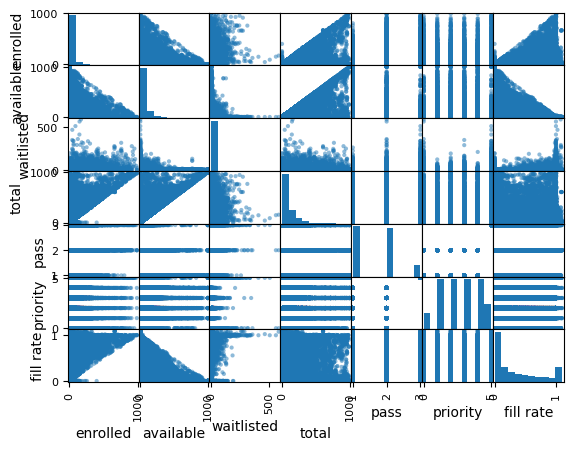

In [30]:
fig1 = pd.plotting.scatter_matrix(df)

From the scatter matrix, we can observe several direct and therefore expected relationships among these variables. For instance, `enrolled` and `total` seats show a positive correlation - courses with larger capacities naturally tend to have more students enrolled. Conversely, `available` seats generally exhibit a negative relationship with `enrolled` seats, meaning that as enrollment increases, the number of open seats decreases. This inverse trend also appears in relation to `fill rate`, since a higher fill rate typically corresponds to fewer available seats.

`waitlisted` seats, while more variable, often appear higher in courses with large enrollments, suggesting that high-demand classes are more prone to waitlists. Meanwhile, `pass` and `priority` are discrete variables, and their scatter plots reveal distinct clusters rather than continuous patterns. The diagonal histograms for each variable confirm these observations and highlight the overall distributions (e.g., showing that some variables are more skewed than others). Collectively, these patterns reinforce standard enrollment dynamics—larger classes attract more students, leading to fewer open seats and potentially larger waitlists — while also highlighting the role of discrete registration passes and priority levels in shaping enrollment outcomes.

Let's explore the distributions of some of these columns.

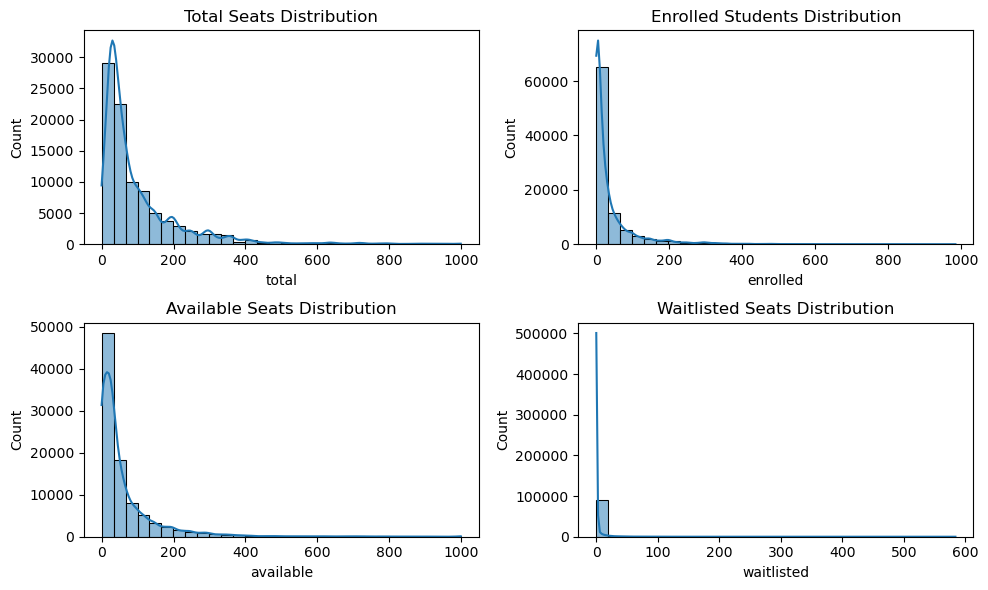

In [31]:
fig2, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# distribution of total seats
sns.histplot(x='total', bins=30, kde=True, data=df, ax=axes[0])
axes[0].set_title("Total Seats Distribution")

# distribution of enrolled seats
sns.histplot(x='enrolled', bins=30, kde=True, data=df, ax=axes[1])
axes[1].set_title("Enrolled Students Distribution")

# distribution of available seats
sns.histplot(x='available', bins=30, kde=True, data=df, ax=axes[2])
axes[2].set_title("Available Seats Distribution")

# distribution of waitlisted seats
sns.histplot(x='waitlisted', bins=30, kde=True, data=df, ax=axes[3])
axes[3].set_title("Waitlisted Seats Distribution")

plt.tight_layout()
plt.show()

From the histograms, we can see that `total` seats, `enrolled` seats, `available` seats, and even `waitlisted` seats (to a lesser extent) all display **right-skewed distributions**. This indicates that while the majority of classes are relatively small or moderate in size, there is a long tail of courses with very large capacities and/or enrollments. In other words, most courses fall into a lower range (for example, under 300 seats), but a few courses can have capacities of several hundred students, creating that skew. This pattern is typical for large universities, where most classes are small or medium-sized discussions, labs, or seminars, while a smaller subset consists of large lecture classes.

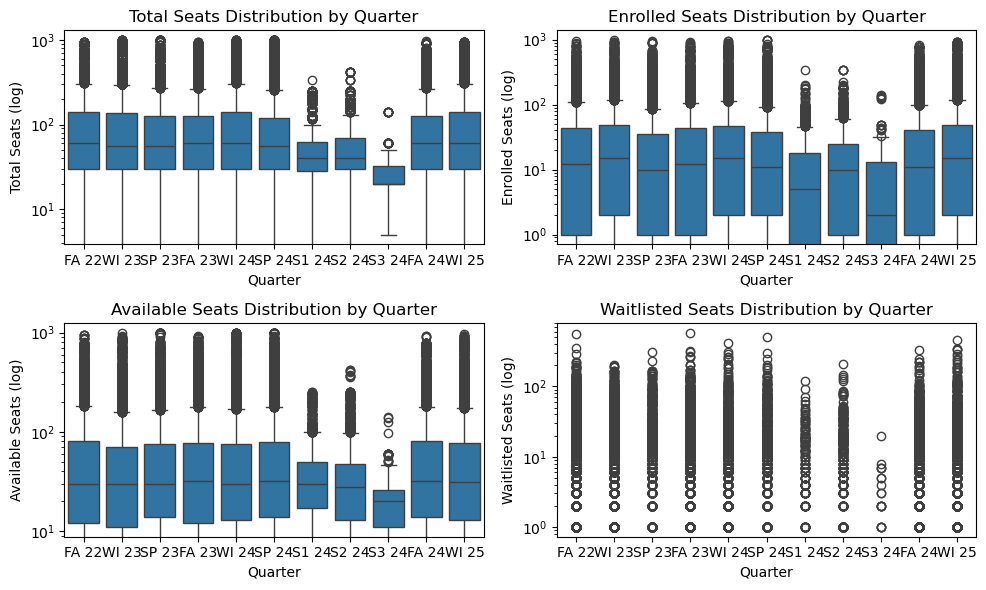

In [32]:
fig3, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# distribution of total seats by quarter
sns.boxplot(x="quarter", y="total", data=df, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_xlabel("Quarter")
axes[0].set_ylabel("Total Seats (log)")
axes[0].set_title("Total Seats Distribution by Quarter")

# distribution of enrolled seats by quarter
sns.boxplot(x="quarter", y="enrolled", data=df, ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Enrolled Seats (log)")
axes[1].set_title("Enrolled Seats Distribution by Quarter")

# distribution of available seats by quarter
sns.boxplot(x="quarter", y="available", data=df, ax=axes[2])
axes[2].set_yscale("log")
axes[2].set_xlabel("Quarter")
axes[2].set_ylabel("Available Seats (log)")
axes[2].set_title("Available Seats Distribution by Quarter")

# distribution of waitlisted seats by quarter
sns.boxplot(x="quarter", y="waitlisted", data=df, ax=axes[3])
axes[3].set_yscale("log")
axes[3].set_xlabel("Quarter")
axes[3].set_ylabel("Waitlisted Seats (log)")
axes[3].set_title("Waitlisted Seats Distribution by Quarter")

plt.tight_layout()
plt.show()

Looking at the **box plots by quarter** helps confirm and visualize these skewed distributions. The medians (middle lines in the box) are generally quite low compared to the upper ranges, and there are numerous outliers (the dots beyond the whiskers) representing exceptionally large classes. An interesting note is that the *summer session 'quarters'* consistently show the lowest averages among all quarters in the box plots of all four variables. This is not surprising, given the fact that these sessions typically see significantly lower student enrollment compared to traditional quarters (Fall, Winter, and Spring).

The log-scale y-axis in the box plots makes it easier to see these differences across quarters; without the log scale, the very large classes could dominate the plot and make it hard to distinguish differences among the smaller and more typical courses.

Based on the plots, we can derive the following insights:

1. `total` seats: The total seats box plots show that most courses across all quarters have capacities well under a few hundred seats, but some can accommodate significantly more — as evidenced by the presence of a handful of outliers close to the thousands mark.

2. `enrolled` seats: The number of enrolled seats also follows a similar pattern. Most courses have enrollments under a few hundred, with a few outliers close to the thousands mark.

3. `available` seats: Just like the `total` and `enrolled` seats, the number of enrolled seats stays consistent across most quarters, with courses having under a hundred seats on average.

4. `waitlisted` seats: The histogram for waitlisted seats tends not to be very informative, likely because a large portion of classes either do not use a waitlist system or never reach capacity (so the waitlist stays at zero). This results in a high concentration of zero values, making the distribution appear unhelpful or “flat” except for a few classes that might have large waitlists.

Overall, these **right-skewed** distributions are expected in higher education data, where a majority of classes fall within a moderate range, and a small subset are either extremely large or experience high demand (leading to high enrollment or waitlists). The box plots underscore these observations by quarter, suggesting that while each term may vary slightly in median course size or enrollment, the same fundamental skewed pattern persists.

Let's also plot the distribution of fill rates to see if any interesting patterns emerge.

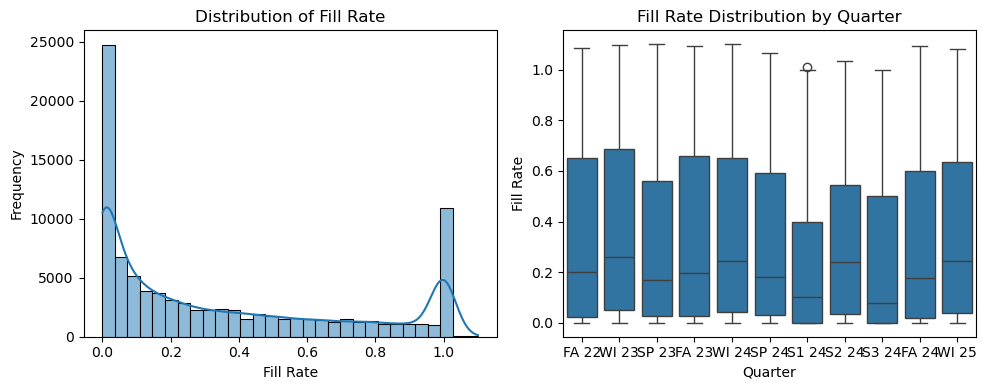

In [33]:
fig4, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# distribution of fill rate
sns.histplot(x="fill rate", bins=30, kde=True, data=df, ax=axes[0])
axes[0].set_xlabel("Fill Rate")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Fill Rate")

sns.boxplot(x="quarter", y="fill rate", data=df, ax=axes[1])
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Fill Rate")
axes[1].set_title("Fill Rate Distribution by Quarter")

plt.tight_layout()
plt.show()

The **histogram of fill rates** shows a **right-skewed distribution**, meaning that most courses have relatively low fill rates, but there are some with significantly higher values. The highest count is observed at **0**, which suggests that many courses have little to no enrollment at the time the data was collected. This could be due to a variety of reasons, such as newly added sections that have not yet filled, special topics courses with low demand, or courses designed to accommodate far more students than typically enroll.

Interestingly, the histogram also exhibits a **spike at 1**, meaning a substantial number of courses reach full capacity. This is expected in a university setting where certain high-demand courses (especially core or major-requirement courses) frequently fill up completely, leading to waitlists or enrollment restrictions. This spike at 1 suggests that a nontrivial proportion of courses are operating at maximum capacity, likely necessitating additional sections or enrollment management strategies.

The **box plot of fill rates by quarter** reveals that the distribution of fill rates remains fairly consistent across quarters, meaning that regardless of the term, courses tend to fill at similar rates. The **interquartile range (IQR)** is mostly **between 0 and 0.5**, indicating that at least 50% of courses (from Q1 to Q3) have fill rates in this range, with many courses enrolling less than half their capacity.

This suggests that, on average, courses are not filling up entirely, and many have substantial open seats available. However, the existence of outliers and the spike at 1 in the histogram suggests that while most courses have lower fill rates, some do reach full capacity each quarter, possibly driven by limited seat availability in high-demand courses.

The consistency across quarters suggests that enrollment behaviors and course availability remain stable over time, with no major fluctuations in how full courses tend to get. This stability may indicate that UCSD (or the institution being analyzed) has a relatively predictable pattern of course demand and availability, with no major structural shifts in how students enroll in courses across different terms.

Let's plot the number of available seats by our variables of interest: pass and priority.

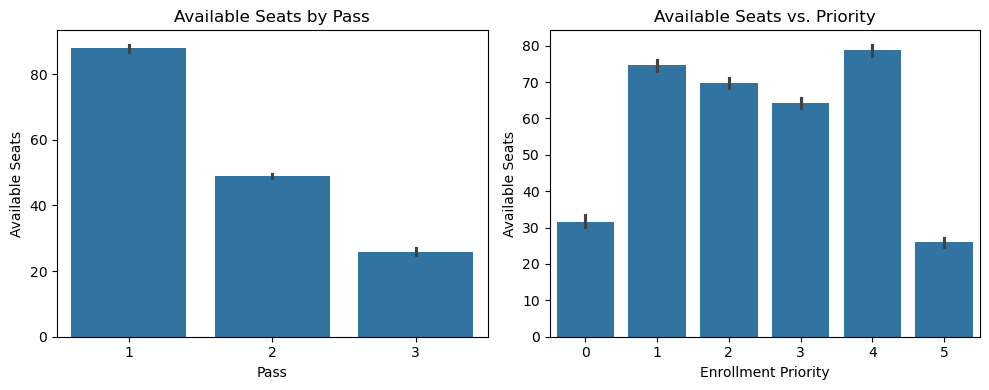

In [34]:
fig4, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# number of available seats by pass
sns.barplot(x="pass", y="available", data=df, ax=axes[0])
axes[0].set_xlabel("Pass")
axes[0].set_ylabel("Available Seats")
axes[0].set_title("Available Seats by Pass")

# number of available seats vs. priority
sns.barplot(x="priority", y="available", data=df, ax=axes[1])
axes[1].set_xlabel("Enrollment Priority")
axes[1].set_ylabel("Available Seats")
axes[1].set_title("Available Seats vs. Priority")

plt.tight_layout()
plt.show()

The graphs show a clear decreasing trend in available seats as registration progresses from passes 1 to 3, which aligns with our expectations — more students register over time, naturally reducing the number of open seats. Available seats with priority follow a similar downward pattern, indicating that higher-priority students (1-2) have more seats available to them on average than lower-priority students (3-4).

However, the observation that available seats spike in  priority 4 is an intriguing anomaly that could be explained by several factors:

1. **Administrative Adjustments**: It’s possible that between junior (3) and freshmen (4) enrollment during each pass, the administration may have adjusted course capacities. For instance, additional seats might be added to high-demand courses to accommodate more students or to address capacity issues, leading to a sudden increase in available seats.

2. **Changes/Withdrawals during Registration**: As registration progresses, some students may drop or cancel their courses. These changes might be processed and reflected in the priority 4 data, temporarily increasing the count of available seats after the enrollment surge during priorities 1-3.

3. **Policy Changes and Waitlist Dynamics**: Another possibility is that registration policies might change as the term progresses. If courses with high enrollment in pass 1 are reopened for additional enrollment in pass 2, or if waitlisted students convert to enrolled status during pass 2, the process might temporarily increase the number of seats marked as “available” before final adjustments are made.

Overall, while the downward trend from pass 1 to pass 2 confirms our expectations that enrollments reduce available seats over time, the spike in available seats in priority 4 suggests that additional administrative actions, student withdrawals during registration, or policy changes might be at work. A deeper dive into the enrollment policies and data handling processes would be necessary to pinpoint the exact reasons behind this anomaly.

Next, let's look at the distribution of courses across departments, starting with the number of courses offered by each department and computing the top ten most enrolled courses overall.

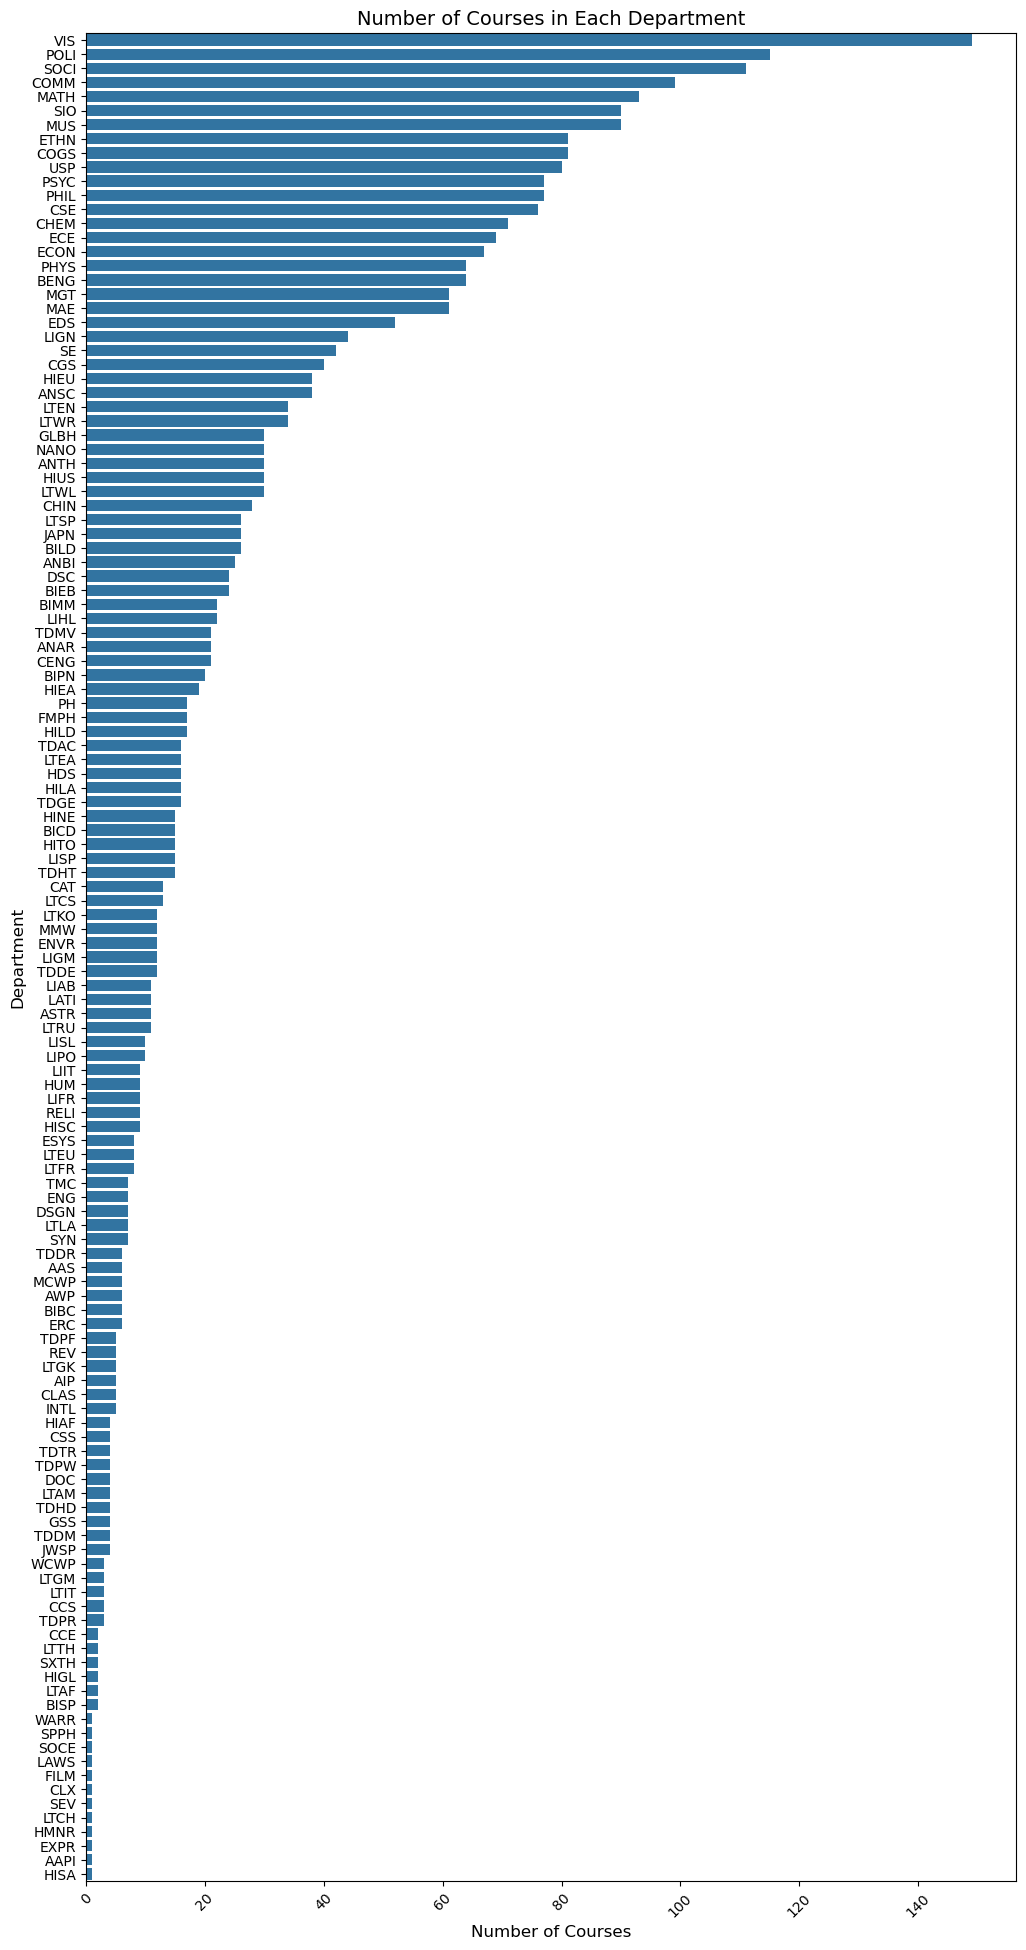

In [35]:
depts = pd.Series(df["course"].unique()).str.split().str[0]

# Count the number of courses per department
dept_counts = depts.value_counts()

# Plot bar chart
plt.figure(figsize=(12, 24))
sns.barplot(y=dept_counts.index, x=dept_counts.values)

# Add labels and title
plt.ylabel("Department", fontsize=12)
plt.xlabel("Number of Courses", fontsize=12)
plt.title("Number of Courses in Each Department", fontsize=14)
plt.xticks(rotation=45)  # Rotate for readability

# Show the plot
plt.show()

The distribution of courses across departments reveals that **Visual Arts (VIS)** offers the highest number of courses, while most **STEM departments** fall somewhere in the middle in terms of course count. This observation is relevant because it highlights how different departments structure their curricula — departments like Visual Arts may offer a greater variety of specialized courses, possibly due to the nature of creative disciplines requiring diverse, smaller-scale classes focused on specific techniques or mediums.

Understanding these differences provides context for enrollment trends in courses from different departments. For example, departments with a higher number of courses might have lower enrollment per course on average, whereas departments with fewer but larger courses (common in STEM) may experience higher fill rates and waitlists. This can help us interpret patterns in seat availability and enrollment demand across different disciplines, which will be useful in interpreting the results from our predictive model for different courses (and departments).

Let's also compute the mean fill rate for each department.

/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_15902/1197521196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['department'] = df["course"].str.split().str[0]


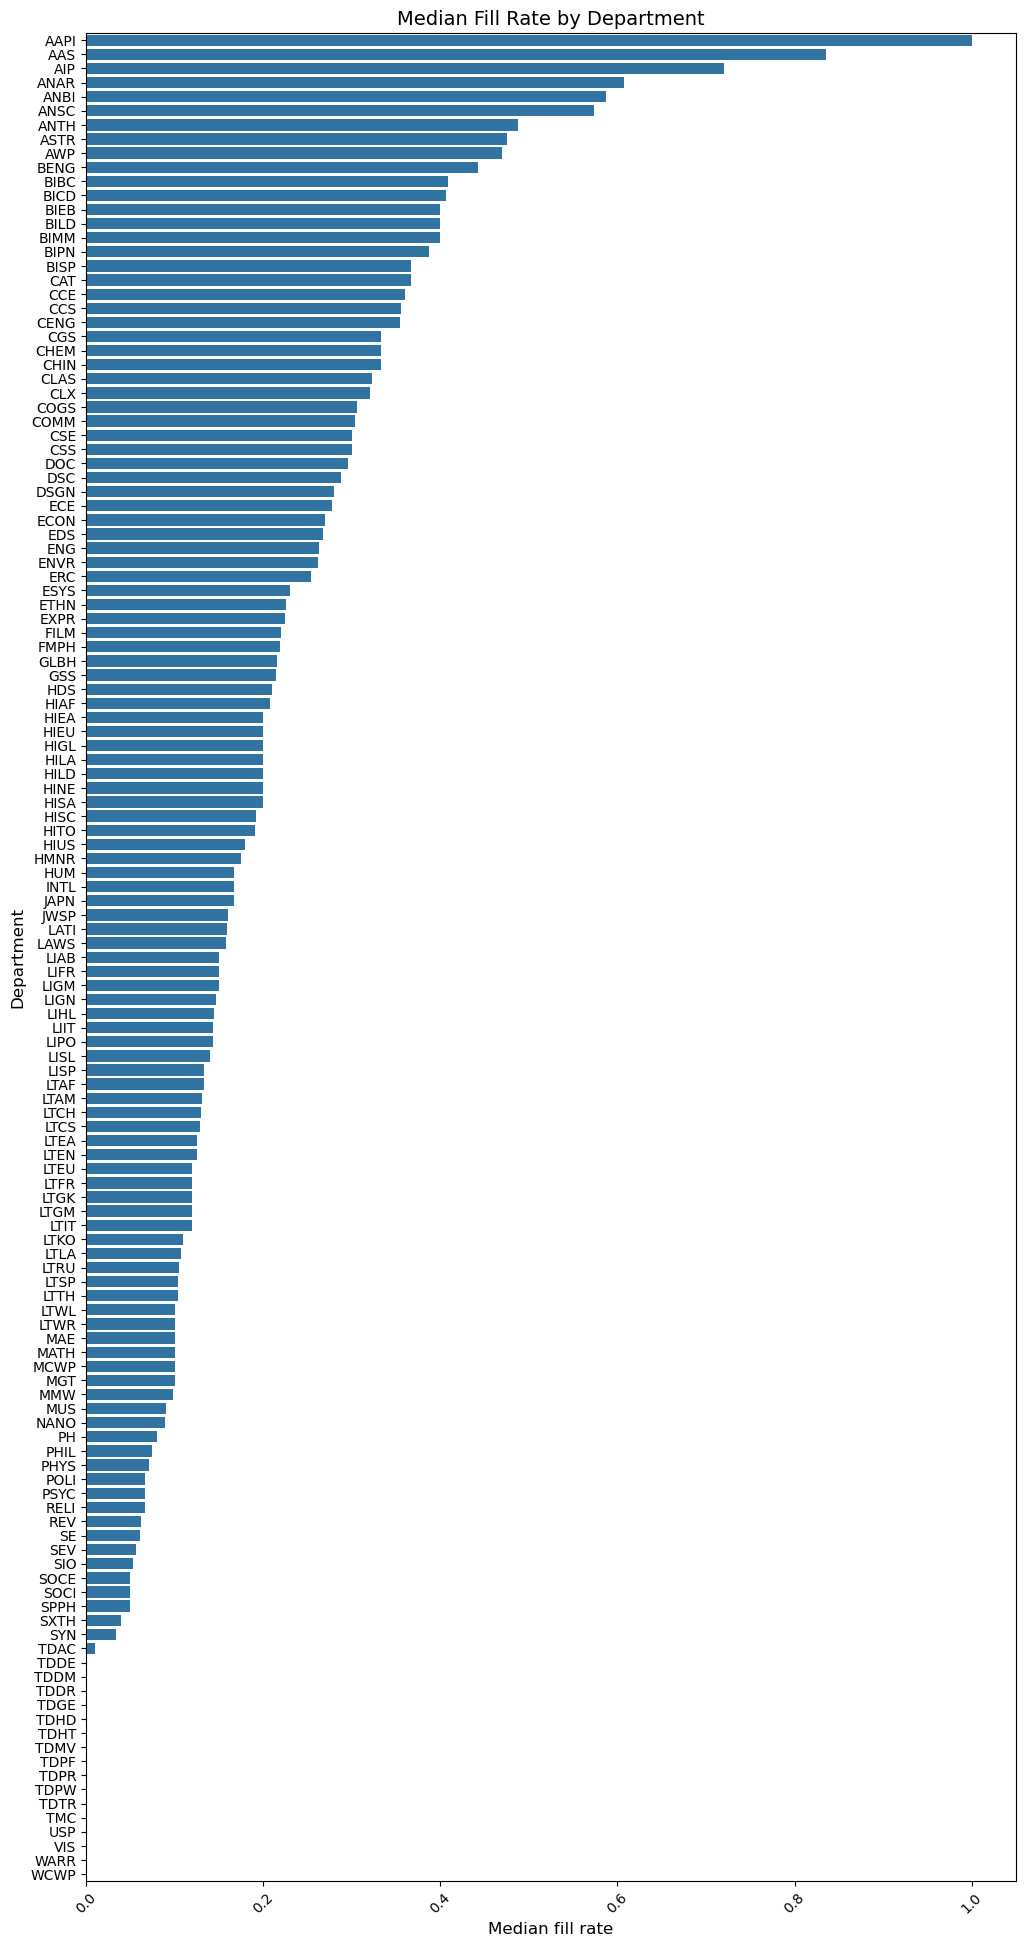

In [36]:
df['department'] = df["course"].str.split().str[0]
df

avg_fill_rate_by_dept = df.groupby('department')['fill rate'].median()
avg_fill_rate_by_dept

# Plot bar chart
plt.figure(figsize=(12, 24))
sns.barplot(y=avg_fill_rate_by_dept.index, x=avg_fill_rate_by_dept.sort_values(ascending=False))

# Add labels and title
plt.ylabel("Department", fontsize=12)
plt.xlabel("Median fill rate", fontsize=12)
plt.title("Median Fill Rate by Department", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.show()

The graph displaying **median fill rates by department** provides valuable insight into which departments consistently reach capacity. Notably, STEM departments like Biology (BILD, BICD, etc.) exhibit some of the highest median fill rates, indicating that demand for these courses frequently exceeds available seats. This trend is likely driven by multiple factors:

1. **High Enrollment Demand**: Biology and other STEM courses are often required for multiple majors, including Biology, Pre-Med, Data Science, and Bioengineering, leading to consistently high enrollment pressures.

2. **Limited Course Offerings**: Unlike some humanities or arts programs that may offer multiple specialized electives, STEM courses tend to have fewer sections with larger student capacities, making it harder for students to secure a spot.

3. **Prerequisite Structure**: Many STEM courses are strictly sequential, meaning students must complete them in a specific order to stay on track for graduation. This creates predictable spikes in demand, especially for gateway courses like BILD 1, BICD 100, or CHEM 6A.

4. **Impact of Lab Components**: Courses with lab sections often have limited seating due to space and resource constraints, leading to higher competition for enrollment.

The median fill rate by department provides valuable insight into how enrollment demand varies across different fields of study. Departments with consistently high median fill rates, such as Biology, tend to have courses that fill up quickly, leading to fewer open seats on average. On the other hand, departments with lower fill rates may exhibit greater variability in seat availability, with some courses regularly filling up while others remain open longer.

Since our model takes course name as an input, it implicitly incorporates department-level enrollment trends. This means that courses from high-demand departments will likely contribute to predictions of lower open-seat availability, whereas courses from departments with lower median fill rates may have more open seats on average.

Understanding these patterns is crucial for accurately forecasting seat availability, as department-wide enrollment trends reflect broader student demand and competition for courses. This allows our model to make more informed predictions about which courses are likely to have open seats, helping students optimize their course selection strategies.

Now that we've visualized overall enrollment trends in our data, let’s explore how seat availability changes over first, second, and third pass for a specific course in a given quarter, allowing us to see how individual courses align with broader enrollment trends.

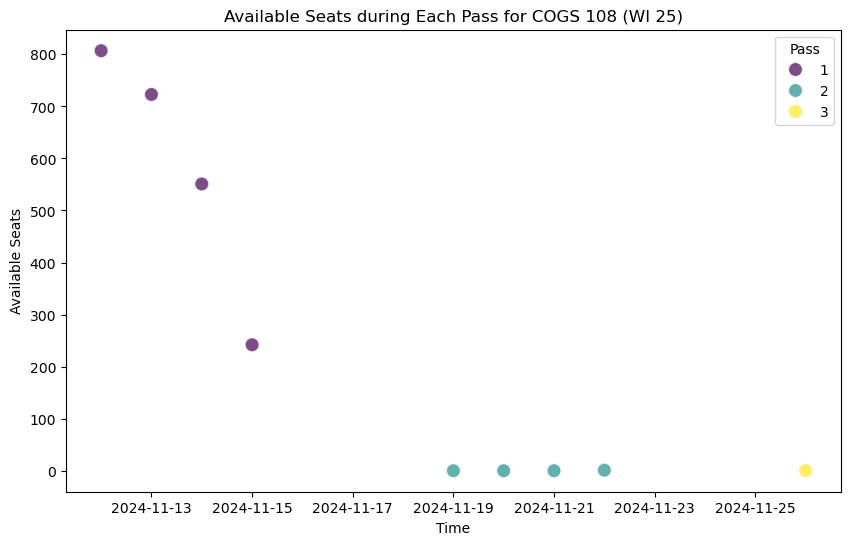

In [37]:
course_name = "COGS 108"  # Change to the course you want
quarter_name = "WI 25"  # Change to the quarter you want

df_filtered = df[(df["course"] == course_name) & (df["quarter"] == quarter_name)]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="time", y="available", hue="pass", palette="viridis", s=100, alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Available Seats")
plt.title(f"Available Seats during Each Pass for {course_name} ({quarter_name})")
plt.legend(title="Pass")

# Show the plot
plt.show()

Visualizing the number of **available seats** during each pass **for a particular course** in a given quarter allows us to observe enrollment trends and how seat availability changes throughout the registration process at a granular level. While this is insightful for understanding a single course’s enrollment behavior, our model is designed to use data from all courses and quarters to predict open seats more broadly. Identifying general trends across multiple courses and enrollment periods is crucial because different courses exhibit different patterns of availability—some may fill up entirely in the first pass, while others might have open seats well into the third pass or even after classes begin.

By analyzing these trends in aggregate, we can recognize key factors influencing seat availability, such as course popularity, department-specific enrollment behaviors, and quarter-based fluctuations. For example, high-demand courses in STEM fields may experience rapid enrollment in earlier passes, while general education or elective courses might see steadier enrollment across multiple passes. Understanding these variations allows us to refine our predictive model, ensuring it captures the nuances of different courses and departments rather than relying on course-specific trends alone.

Ultimately, while individual visualizations help illustrate specific cases, the strength of our model lies in its ability to generalize across the entire dataset. By comprehensively analyzing how seat availability evolves throughout the enrollment process, we can improve our predictions and provide more accurate insights into which courses are likely to have open seats at any given stage.

### Analysis

First, let's take a look at `fill rate` and its effect on seat `availability` as it can be used to help determine the effect of other variables. If there is a strong correlation, a strong effect on fill rate from other variables will also mean a strong effect on seat availability.

In [39]:
# Separate df so we can look specifically into first and second pass
df_first = df[df['pass'] == 1]
df_second = df[df['pass'] == 2]

/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3535536465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["available_bin"] = pd.cut(df["available"], bins=bins, labels=labels)
/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3535536465.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["available_bin"], y=df_first["fill rate"], palette=colors, ax=axes[0])
/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3535536465.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

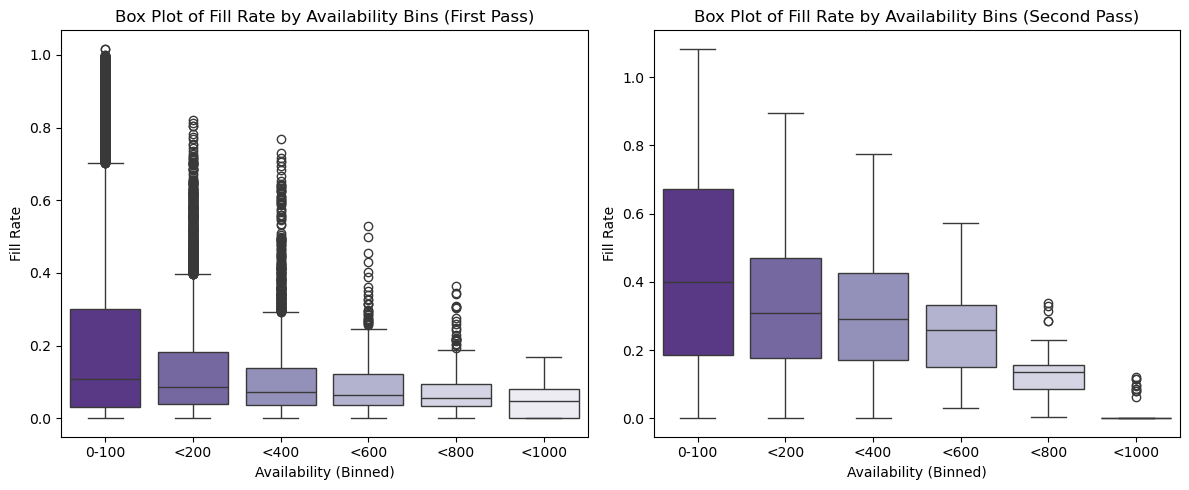

In [40]:
# Create bins for a cleaner plot
bins = [0, 100, 200, 400, 600, 800, 1000]
labels = ["0-100", "<200", "<400", "<600", "<800", "<1000"]
df["available_bin"] = pd.cut(df["available"], bins=bins, labels=labels)

# Create color gradient
colors = list(reversed(sns.color_palette("Purples", len(labels))))

# Create subplots (so plots are side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create box plot for first pass
sns.boxplot(x=df["available_bin"], y=df_first["fill rate"], palette=colors, ax=axes[0])

# Create box plot for second pass
sns.boxplot(x=df["available_bin"], y=df_second["fill rate"], palette=colors, ax=axes[1])

# Customize labels
axes[0].set_xlabel("Availability (Binned)")
axes[0].set_ylabel("Fill Rate")
axes[0].set_title("Box Plot of Fill Rate by Availability Bins (First Pass)")

axes[1].set_xlabel("Availability (Binned)")
axes[1].set_ylabel("Fill Rate")
axes[1].set_title("Box Plot of Fill Rate by Availability Bins (Second Pass)")

plt.tight_layout()
plt.show()

In [41]:
# Calculate Pearson correlation between available seats and fill rate during first pass
corr_1, p_val_1 = stats.pearsonr(df_first['available'], df_first['fill rate'])
print(f"Pearson Correlation: {corr_1}, p-value: {p_val_1}")

# Calculate Pearson correlation between available seats and fill rate during second pass
corr_2, p_val_2 = stats.pearsonr(df_second['available'], df_second['fill rate'])
print(f"Pearson Correlation: {corr_2}, p-value: {p_val_2}")

Pearson Correlation: -0.23927477518548962, p-value: 0.0
Pearson Correlation: -0.31508783902159404, p-value: 0.0


From these box plots, we can observe that for both first and second pass, higher fill rates tend to lead to fewer available seats. The calculated Pearson correlation confirms this as we get a p-value that is so small that it returns as 0, indicating that there is a very strong negative correlation between available seats and fill rate. We also noticed that first pass tends to have lower fill rates than second pass. This suggests that not all courses reach high fill rates immediately and that there are generally more open seats during first pass. By the time second pass occurs, more students have registered, leading to an overall increase in median fill rates. In other words, it is more difficult to find available seats during second pass, so it would be advised to secure more desired courses during first pass, as one would expect. 

We can now compare `fill rate` to course `capacity`. 

We already intuitively know that a larger capacity will mean that there will be more seats. For example, a course with a capacity of 20 will already have fewer seats than a course with a capacity of 200. This doesn't necessarily mean that it determines how difficult it will be to secure a seat though. There could be a difference in demand that makes the course of 200 capacity fill up faster (have a high fill rate), and thus having fewer available seats, than the course of 20 capacity which barely fills up at all (low fill rate). 

/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3910157049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first["capacity_bin"] = pd.cut(df_first["total"], bins=bins, labels=labels)
/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3910157049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second["capacity_bin"] = pd.cut(df_second["total"], bins=bins, labels=labels)
/var/folders/0_/22_f2m016_q28g18s19mxwrh0000gn/T/ipykernel_13051/3910157049.py:14: FutureWarning

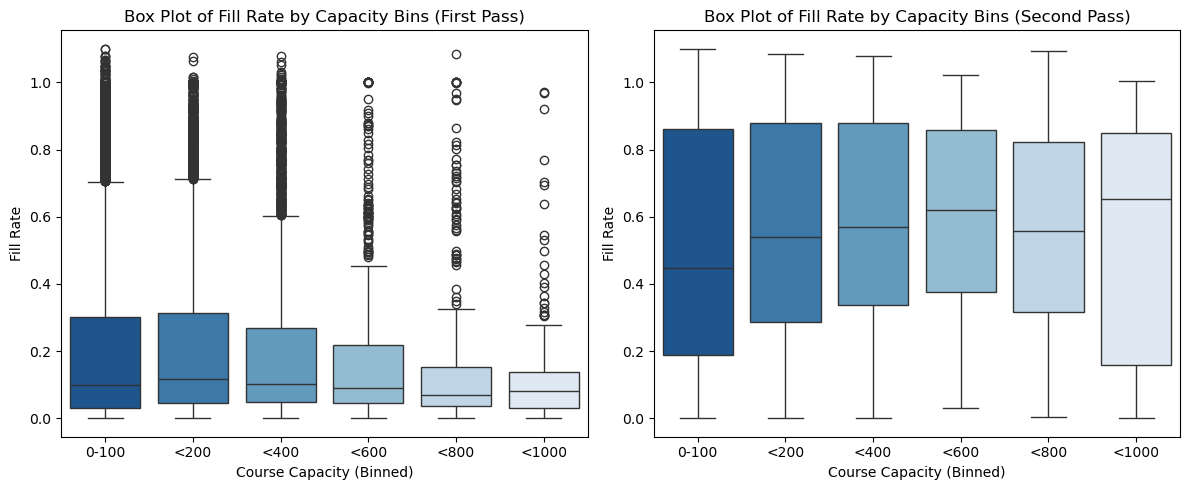

In [42]:
# Create bins for a cleaner plot
bins = [0, 100, 200, 400, 600, 800, 1000]
labels = ["0-100", "<200", "<400", "<600", "<800", "<1000"]
df_first["capacity_bin"] = pd.cut(df_first["total"], bins=bins, labels=labels)
df_second["capacity_bin"] = pd.cut(df_second["total"], bins=bins, labels=labels)

# Create color gradient
colors = list(reversed(sns.color_palette("Blues", len(labels))))

# Create subplots (so plots are side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create box plot for first pass
sns.boxplot(x=df_first["capacity_bin"], y=df_first["fill rate"], palette=colors, ax=axes[0])

# Create box plot for first pass
sns.boxplot(x=df_second["capacity_bin"], y=df_second["fill rate"], palette=colors, ax=axes[1])

# Customize labels
axes[0].set_xlabel("Course Capacity (Binned)")
axes[0].set_ylabel("Fill Rate")
axes[0].set_title("Box Plot of Fill Rate by Capacity Bins (First Pass)")

axes[1].set_xlabel("Course Capacity (Binned)")
axes[1].set_ylabel("Fill Rate")
axes[1].set_title("Box Plot of Fill Rate by Capacity Bins (Second Pass)")

plt.tight_layout()
plt.show()

In [43]:
# Calculate Pearson correlation between capacity and fill rate during first pass
corr_1, p_val_1 = stats.pearsonr(df_first['total'], df_first['fill rate'])
print(f"First pass:")
print(f"Pearson Correlation: {corr_1}, p-value: {p_val_1}\n")

# Calculate Pearson correlation between capacity and fill rate during second pass
corr_2, p_val_2 = stats.pearsonr(df_second['total'], df_second['fill rate'])
print(f"Second pass:")
print(f"Pearson Correlation: {corr_2}, p-value: {p_val_2}")

First pass:
Pearson Correlation: -0.010808655715213075, p-value: 0.026754048353716586

Second pass:
Pearson Correlation: 0.12543724358835015, p-value: 1.4698845374403843e-141


The graphs above look into how fast courses of a different range of capacities fill up during first and second pass. From this, we observe two different kinds of relationships. For first pass, there is a negative correlation. For second pass, there is a positive correlation. The negative correlation suggests that courses with smaller capacities are in higher demand during first pass, therefore filling up faster, making it less likely to have available seats in those courses. The positive correlation suggests that after securing those smaller classes, students are now prioritizing larger course capacities.

Now let’s analyze how enrollment counts differ across `priority` levels and `quarters`. 

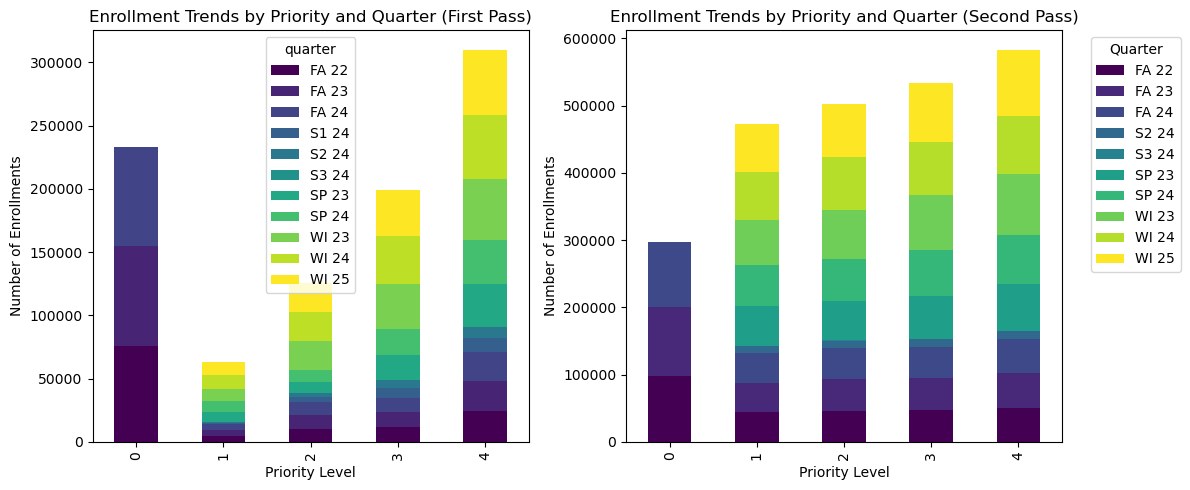

In [45]:
# group and count enrollments by priority and quarter
enrollment_trends_1 = df_first.groupby(['priority', 'quarter', 'course']).max().reset_index()\
                    .groupby(['priority', 'quarter'])['enrolled'].sum().unstack()
enrollment_trends_2 = df_second.groupby(['priority', 'quarter', 'course']).max().reset_index()\
                    .groupby(['priority', 'quarter'])['enrolled'].sum().unstack()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot results (first pass)
enrollment_trends_1.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[0])

# plot results (second pass)
enrollment_trends_2.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[1])

# Labeling
axes[0].set_title("Enrollment Trends by Priority and Quarter (First Pass)")
axes[0].set_xlabel("Priority Level")
axes[0].set_ylabel("Number of Enrollments")

axes[1].set_title("Enrollment Trends by Priority and Quarter (Second Pass)")
axes[1].set_xlabel("Priority Level")
axes[1].set_ylabel("Number of Enrollments")

plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From the bar chart above, it can be seen that enrollments are consistent across all quarters, with number of enrollements increasing with higher priority, which is expected.

Seasonal trends are also evident in the data. Fall quarters (FA 22, FA 23, FA 24) consistently show the lowest number of enrollments compared to Winter and Spring quarters (WI 23, WI, 24, WI 25, SP 23, SP 24). This is expected because seniors typically do not enroll in classes for fall quarter next year since they are graduating, so the number of enrollment is drastically lower. Spring quarters also show lower enrollments than Winter quarters because a significant number of students graduate after Winter quarter every year.

Having explored enrollment trends, we now shift to explore how fill rates vary across priority levels and quarters to observe key patterns in course utilization. To do this, the average fill rates were aggregated into a pivot table and visualized using a heatmap.

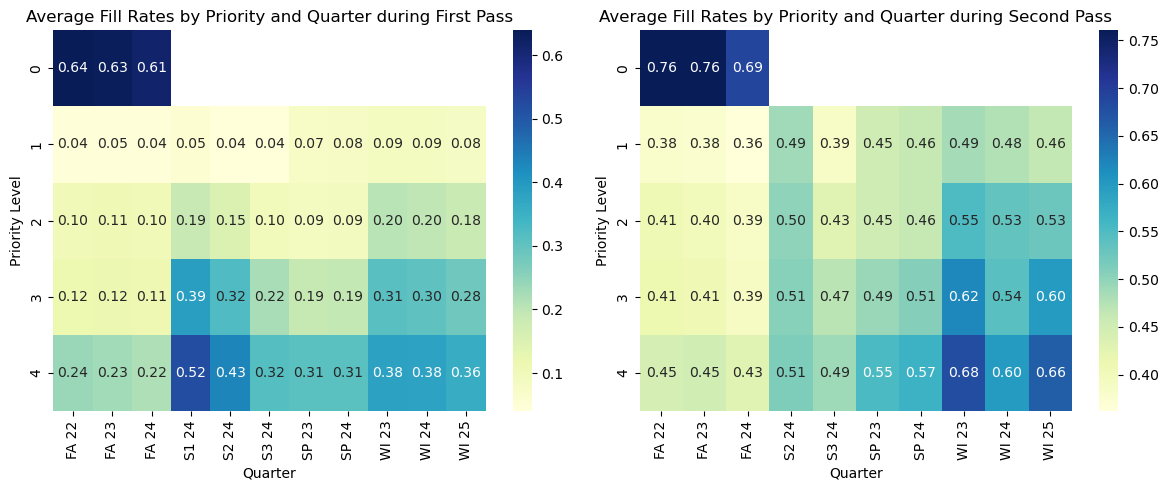

In [46]:
# pivot tables for corresponding first pass and second pass heatmap
pivot_1 = df_first.pivot_table(values="fill rate", index="priority", columns="quarter", aggfunc="mean")
pivot_2 = df_second.pivot_table(values="fill rate", index="priority", columns="quarter", aggfunc="mean")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# generate heatmap for first pass
sns.heatmap(pivot_1, ax=axes[0], cmap="YlGnBu", annot=True, fmt=".2f")
axes[0].set_title("Average Fill Rates by Priority and Quarter during First Pass")
axes[0].set_xlabel("Quarter")
axes[0].set_ylabel("Priority Level")

# generate heatmap
sns.heatmap(pivot_2, ax=axes[1], cmap="YlGnBu", annot=True, fmt=".2f")
axes[1].set_title("Average Fill Rates by Priority and Quarter during Second Pass")
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Priority Level")

plt.tight_layout()
plt.show()

From the heatmap, we observe that high priority levels (1 and 2) tend to have lower fill rates, averaging between 0.04 and 0.20 during first pass and 0.38-0.55 in second pass. This trend is consistent with expectations, as higher-priority students (juniors/seniors) are typically granted earlier access to courses than lower-priority students (freshmen/sophomores). In contrast, lower priority levels (3 and 4) exhibit significantly higher fill rates, often exceeding 0.6, reflecting their disadvantage in enrolling in high-demand courses.

Fill rates appear relatively stable across Fall quarters (e.g., FA 22, FA 23, and FA 24), with higher fill rates compared to other terms. However, there is noticeable variability in Winter quarters (e.g., WI 23, WI 24 and WI 25) and greater inconsistency in Summer quarters (S1 24, S2 24, and S3 24).

Additionally, the gap in fill rates between priority groups highlights disparities in course access. For instance, during first pass, there is a large gap between Priority 0 and other groups in fall quarters (as high as nearly tripling the rates). During second pass, the gap lessens, but there is still a noticeable gap, which is higher than the gaps between the other groups. Now, if we shift our attention away from this special enrollment priority and look towards regular priorities from 1-4, we can still see that higher-priority groups consistently exhibit lower fill rates, illustrating their advantage in accessing available courses during earlier registration phases.

Okay so now when it comes to assess whether the observed differences in average fill rates across priority levels are statistically significant, we perform a one-way Analysis of Variance (ANOVA). This test evaluates whether the mean fill rates differ significantly between the groups (priority levels).

In [47]:
from scipy.stats import f_oneway

# group fill rates by priority (first pass)
groups_priority = [group["fill rate"] for _, group in df_first.groupby("priority")]
f_stat, p_value = f_oneway(*groups_priority)

print(f"ANOVA Test - F-Statistic: {f_stat}, P-Value: {p_value}")

# group fill rates by priority (second pass)
groups_priority = [group["fill rate"] for _, group in df_second.groupby("priority")]
f_stat, p_value = f_oneway(*groups_priority)

print(f"ANOVA Test - F-Statistic: {f_stat}, P-Value: {p_value}")

ANOVA Test - F-Statistic: 4170.3318596591225, P-Value: 0.0
ANOVA Test - F-Statistic: 531.6888064151165, P-Value: 0.0


While the ANOVA test indicates that there are significant differences in mean fill rates across priority levels, it does not specify which priority levels differ from one another. So lets address this by performing Tukey's Honest Significant Difference (HSD) test as a post-hoc analysis. This test will compare all possible pairs of priority levels to determine where the significant differences lie.

In [48]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# conduct Tukey's HSD post-hoc test (first pass)
tukey = pairwise_tukeyhsd(endog=df_first["fill rate"], groups=df_first["priority"], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   -0.562   0.0 -0.5751  -0.549   True
     0      2  -0.4901   0.0 -0.5031  -0.477   True
     0      3  -0.4106   0.0 -0.4237 -0.3975   True
     0      4  -0.3105   0.0 -0.3236 -0.2974   True
     1      2    0.072   0.0  0.0628  0.0812   True
     1      3   0.1515   0.0  0.1423  0.1606   True
     1      4   0.2516   0.0  0.2424  0.2607   True
     2      3   0.0795   0.0  0.0703  0.0886   True
     2      4   0.1796   0.0  0.1704  0.1887   True
     3      4   0.1001   0.0  0.0909  0.1093   True
---------------------------------------------------


In [49]:
# conduct Tukey's HSD post-hoc test (second pass)
tukey = pairwise_tukeyhsd(endog=df_second["fill rate"], groups=df_second["priority"], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.2994   0.0 -0.3184 -0.2804   True
     0      2  -0.2675   0.0 -0.2865 -0.2485   True
     0      3  -0.2366   0.0 -0.2555 -0.2176   True
     0      4  -0.1862   0.0 -0.2052 -0.1672   True
     1      2   0.0319   0.0  0.0184  0.0454   True
     1      3   0.0629   0.0  0.0494  0.0764   True
     1      4   0.1133   0.0  0.0998  0.1268   True
     2      3    0.031   0.0  0.0175  0.0445   True
     2      4   0.0814   0.0  0.0678  0.0949   True
     3      4   0.0504   0.0  0.0369  0.0639   True
---------------------------------------------------


After confirming with the ANOVA test that significant differences exist in average fill rates across priority levels, we used Tukey's Honest Significant Difference (HSD) test to determine which priority levels differ from one another. The results show that all pairwise comparisons between priority levels are statistically significant, with adjusted p-values of 0.0. This indicates that every priority level has meaningful differences in average fill rates compared to others.

The largest differences are observed between Priority 1 and the lower priorities. For instance, Priority 4 has a mean fill rate difference of 0.1133 compared to Priority 1, and Priority 3 has a difference of 0.0629. These values reflect the substantial disparity in course access between the highest and lowest priorities. Even adjacent priorities show significant differences, such as between Priority 3 and Priority 4, where the mean difference (0.0504) is still highly significant. This suggests that students in Priority 3 maintain a slight advantage over those in Priority 4 when it comes to course access.

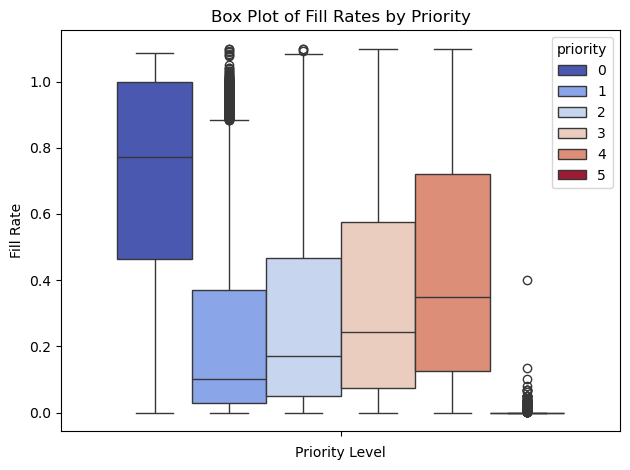

In [50]:
sns.boxplot(hue="priority", y="fill rate", data=df, palette="coolwarm")
plt.title("Box Plot of Fill Rates by Priority")
plt.xlabel("Priority Level")
plt.ylabel("Fill Rate")
plt.tight_layout()
plt.show()

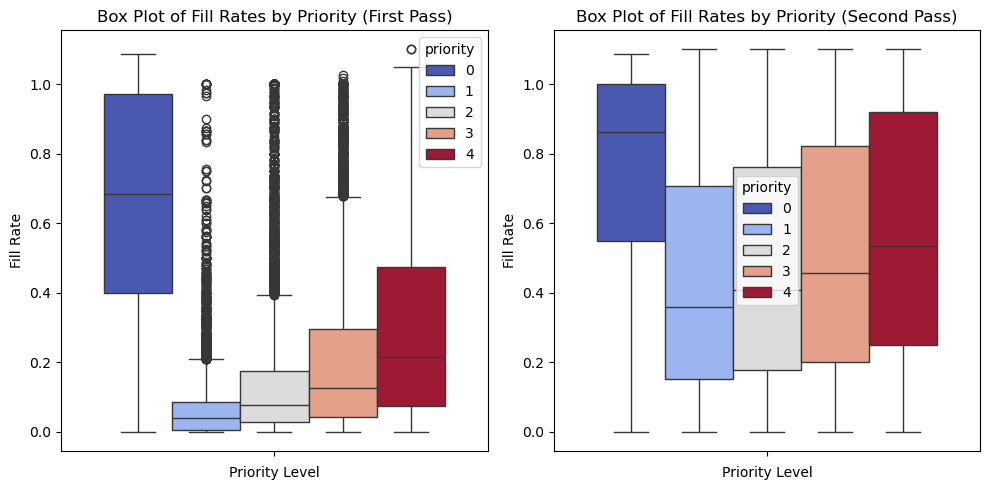

In [51]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create box plots
sns.boxplot(hue="priority", y="fill rate", data=df_first, palette="coolwarm", ax=axes[0])
axes[0].set_title("Box Plot of Fill Rates by Priority (First Pass)")
axes[0].set_xlabel("Priority Level")
axes[0].set_ylabel("Fill Rate")

sns.boxplot(hue="priority", y="fill rate", data=df_second, palette="coolwarm", ax=axes[1])
axes[1].set_title("Box Plot of Fill Rates by Priority (Second Pass)")
axes[1].set_xlabel("Priority Level")
axes[1].set_ylabel("Fill Rate")

plt.tight_layout()
plt.show()

To examine how fill rates differ across priority levels, a box plot was used to visualize the distribution of fill rates for each group. This visualization offers a detailed look at the range, median, and variability of fill rates within each priority, while also highlighting any outliers. The results align with prior findings, showing that lower priorities (3 and 4) tend to have higher median fill rates compared to higher priorities. These groups also display greater variability, suggesting a wider range of outcomes in course utilization. Conversely, higher priorities (1 and 2) generally exhibit lower median fill rates, with Priority 1 showing particularly low and tightly distributed values, indicating limited access to courses for this group.

Outliers appear across all priority levels, potentially reflecting courses that either reached full capacity or experienced unexpectedly low enrollment. This aligns with the findings from Tukey’s HSD test and further illustrates how even within low-priority groups, disparities in course access can exist. Overall, the box plot provides valuable context for understanding the differences in course enrollment across priorities and reinforces the advantage held by students with higher enrollment priorities.


### Summary of Findings 

Our analysis reveals that along with fill rate along with capacity plays a significant role in determining seat availability, and its influence differs between first and second pass registrations. We've observed that smaller-capacity courses tend fill up more quickly during first pass as opposed to second pass where its larger-capacity courses experience higher fill rates. Regarding solely fill rates, higher fill rates are consistently associated with fewer available seats across both first and second pass registrations, reinforcing the idea that fill rate is a strong predictor of seat availability. It's also important to note that there also seems to be a tendency for lower fill rates during first pass than second pass. This indicates that courses do not reach full capacity as quickly in the initial round of enrollment and suggests that it is more difficult to find available seats during second pass.

Additionally, there is a significant impact of enrollment priority levels and seasonal trends (quarters) on fill rates and course enrollment. Higher-priority students consistently achieve greater access to courses, reflected in higher average fill rates and the statistically significant differences observed between priority groups. Seasonal patterns further reveal that Fall quarters typically see lower enrollments compared to Spring and Winter, indicating progressive demand during the course of the academic year. These findings provide important insights into course accessibility and offer a foundation for strategies aimed at improving enrollment processes.

## Building the Predictive Model

For our model, we decided to use the following features: `pass`, `priority`, `total` (total capacity of the course), `quarter` (the quarter season instead of a particular quarter), `course`, `department` (department of the course)

Our response variable is `available` which represents the number of open seats for a course. The reason we chose these factors to predict the number of available seats is because they had a significant statistical relationship open seats available. 

Initially, we also had fill rate (calculated as students enrolled / total capacity) as a feature but we removed it from our prediction model because it creates data leakage, which would invalidate our model's ability to make meaningful predictions for future quarters. There exists a direct mathematical relationship between fill rate, total capacity, and available seats (our response variable), where available seats = total capacity × (1 - fill rate). Including fill rate would essentially give the model the formula to calculate the target rather than forcing it to learn patterns from historical data. Since fill rate represents information that would not be known prior to the actual enrollment period for future quarters, including it would make our model impractical for its intended purpose which is to help students predict seat availability before registration begins. By removing this variable, we ensure our model learns genuinely predictive patterns from historical course data and student factors creating a tool that can make valuable predictions using only information available to students during the course planning phase.

The model we chose was the Random Forest Regression model because of its ability to handle both categorical and numerical features, capturing complex non-linear relationships, and resist being more resistant to overfitting that the regular linear regression. 

Mean Squared Error (MSE): 515.0324253539161
Root Mean Squared Error (RMSE): 22.694325840480833
R-squared (R^2): 0.948801634529844


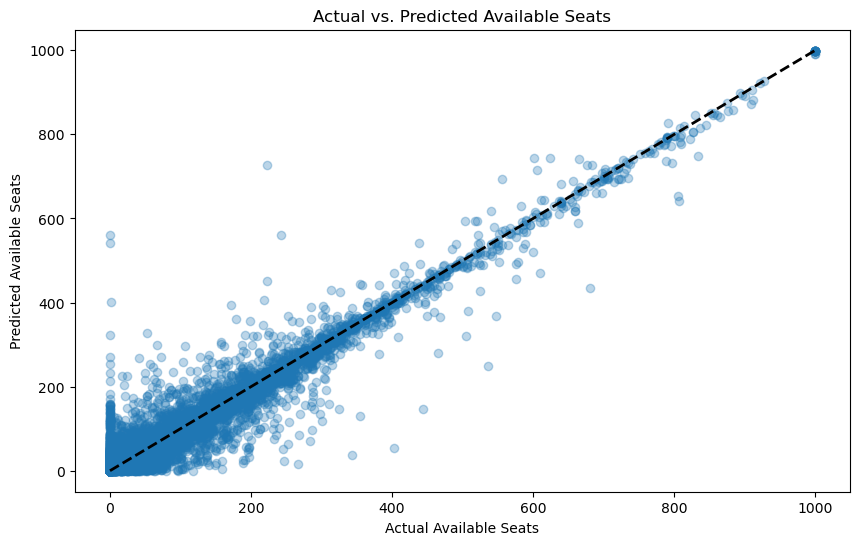

As an example, a sophomore attempting to enroll in COGS 108 during fall quarter, first pass can expect approximately 475.3 available seats.


['open_seats_prediction_model.pkl']

In [52]:
warnings.filterwarnings('ignore')

# extracting quarter season (FA, WI, SP, S1, S2, S3)
df['quarter_season'] = df['quarter'].str.split().str[0]


# selecting the features 
X = df[['pass', 'priority', 'total', 'department', 'course', 'quarter_season']]

# response variable
y = df['available']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# build a pipeline for the model

# defining the categorical and numerical features
categorical_features = ['department', 'course', 'pass', 'priority', 'quarter_season']
numerical_features = ['total']

# setting up the pre-processor for the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# implementing the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# training the model on X_train and y_train
pipeline.fit(X_train, y_train)

# metric used to evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

# plotting actual vs predicted values to understand model performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Available Seats')
plt.ylabel('Predicted Available Seats')
plt.title('Actual vs. Predicted Available Seats')
plt.show()

# creating a prediction function that can be used to find the num. of open seats
def predict_available_seats(course, pass_num, priority, quarter_season, total=None):
    # if total is not provided, use average from data
    if total is None:
        # finding the average total for given course
        course_data = df[df['course'] == course]
        if len(course_data) > 0:
            total = course_data['total'].mean()
        else:
            # if course DNE, using overall average
            total = df['total'].mean()
 
    department = course.split()[0]
    input_data = pd.DataFrame({
        'pass': [pass_num],
        'priority': [priority],
        'total': [total],
        'department': [department],
        'course': [course],
        'quarter_season': [quarter_season]
    })

    # making the prediction
    predicted_seats = pipeline.predict(input_data)[0]

    # returning a non-negative prediction
    return max(0, predicted_seats)

# example
print(f"As an example, a sophomore attempting to enroll in COGS 108 during "
    f"fall quarter, first pass can expect approximately {predict_available_seats('COGS 108', 1, 3, 'FA'):.1f} available seats.")


# checking model metrics across different quarter seasons
quarter_seasons = df['quarter_season'].unique()

joblib.dump(pipeline, 'open_seats_prediction_model.pkl')

### Interpreting the Results:
- R² of 0.949: The model explains about 94.9% of the variance in available seats, which is excellent. This suggests the features we are using are strong predictors of the response variable. 
- RMSE of 22.69: On average, the predictions are off by about 22 seats. This has different consequences for different class sizes. For large classes, this is a small percentage error, but for smaller classes this could be a significant percentage error.
- MSE of 515.03: This metric confirms there's a reasonable amount of variance in the predictions. However, this is to be expected in a real-world model when it is tested on unseen data.
- The scatter plot shows strong predictive performance across the full range of seat numbers but there is more variance in the lower seat ranges (0-200). That being said, the plot shows that the predicted values are especially good for  larger classes (more than 500 seats).

# Ethics & Privacy

Our research follows ethical data science practices while successfully addressing privacy considerations. The primary dataset was obtained from a publicly available GitHub repository released under the MIT License, which explicitly permits usage of the data. We ensured our web scraping methods were respectful of system resources and accessed only intended public information, all while adhering to the rate limits set by GitHub.

While the dataset contains no personally identifiable information (PII), we recognize that enrollment patterns could potentially reveal institutional scheduling strategies or departmental practices that are not meant for the public eye. To address this concern, we have taken care to present findings in an aggregated manner to avoid exposing potentially sensitive academic planning information that could affect a department's operations.

Furthermore, we recognize that our dataset, while comprehensive in tracking enrollment patterns, presents an incomplete picture of course selection patterns. This is because, we did not incorporate many of the qualitative factors such as Course and Professor Evaluations (CAPEs) or Student Evaluation of Teaching (SETs) and Rate My Professor reviews. Instead, we have mostly captured the quantitative aspects of enrollment behavior. In reality, student course selection is often heavily influenced by instructor reputation, perceived course difficulty, and peer recommendations – information that exists primarily in these evaluation systems. The absence of these factors in our model means we are essentialy analyzing and predicting the "what" of enrollment patterns without fully understanding the "why" behind student choices. For instance, a course that consistently fills quickly might do so because of an exceptional instructor rather than other quantitative factors. This limitation potentially affects our model's interpretability and could lead to recommendations that don't account for the qualitative aspects driving the student body's decision making. Future iterations of this research would benefit significantly from integrating these evaluation metrics to create a more holistic understanding of enrollment behaviors at UCSD.

Apart from this,our analysis acknowledges several potential sources of bias. Firstly, data representation may vary across departments and class standings, potentially skewing results towards more heavily represented groups. Secondly, our model's predictive accuracy varies by class size, with smaller courses showing greater relative error margins than larger ones. We've transparently documented these limitations and, to the best of our abilities, ensured that our visualizations faithfully represent the underlying data patterns.

The practical implications of our work extend beyond academic interest. By providing students with better information about course availability patterns, our research aims to promote more equitable access to limited educational resources available here at UCSD. However, we recognize that predictive tools could potentially reinforce existing enrollment inequities if predominantly used by students with greater technical access or data literacy. Future implementations of this project would benefit from a more user-friendly interface that is easily accessible to all students regardless of technical background.

Throughout our project, we maintained transparency about methodological choices, data limitations, and potential biases, following the established data science ethics guidelines. Our goal has been to create a tool that serves the student community here at UCSD all while respecting privacy and institutional practices.


# Discussion & Conclusion

The aim of our project was to identify which combination of course characteristics and student factors best predict open seat availability during UCSD's first and second-pass enrollment periods. Using UCSD's enrollment data spanning 11 quarters (Fall 2022 through Winter 2025), we investigated how course characteristics (department, specific course, quarter season) and student factors (class standing/priority, pass number) influence seat availability during first and second-pass registrations.

After analyzing data and developing a Random Forest Regression model with strong predictive performance (R² = 0.949 and RMSE = 22.69), we can now address our initial hypothesis. We hypothesized that course fill rate and student class standing would most significantly influence seat availability, with higher fill rates and later enrollment periods (due to lower priority) resulting in fewer available seats. Our findings largely support this hypothesis, with statistical analysis confirming significant differences in fill rates across priority levels. As predicted, courses with higher historical fill rates consistently showed fewer available seats, and higher-priority students (seniors, juniors) enjoyed greater course access than lower-priority students (sophomores, freshmen).

Initially, we encountered data leakage issues with variables like fill rate that were mathematically related to our target variable (available seats). After addressing these concerns, our optimized model achieved impressive predictive performance. The scatterplot of actual versus predicted values showed particularly strong accuracy for courses with larger numbers of available seats, with more variance in the lower seat ranges (0-200 seats). These metrics directly answer our research question by confirming that our selected combination of factors can predict the number of open seats with high accuracy.

Our analysis also revealed nuances beyond our initial hypothesis. We discovered that course capacity interacts differently with fill rates during first versus second pass registration. During first pass, smaller-capacity courses tended to fill more quickly, while in second pass, larger-capacity courses showed higher fill rates. Additionally, we identified significant seasonal variations, with Fall quarters exhibiting different enrollment patterns than Winter and Spring terms. Department-specific trends emerged as well, with certain STEM departments (particularly Biology) demonstrating consistently higher fill rates across all quarters.

Despite the strong predictive performance, our project has several important limitations. The model's average error of about 22 seats, while relatively small for large classes, could still significantly impact predictions for smaller courses where such an error might represent a large percentage of a class' capacity. Additionally, our model primarily relies on historical enrollment patterns, which may not perfectly translate to future quarters, especially for new courses or those that have undergone structural and logistical changes.

Furthermore, we recognize that our dataset, while comprehensive in tracking enrollment patterns, presents an incomplete picture of course selection dynamics. By not incorporating qualitative factors such as CAPEs/SETs and Rate My Professor reviews, we've captured only the quantitative aspects of enrollment behavior. Student course selection is often heavily influenced by instructor reputation, perceived course difficulty, and peer recommendations—information that exists primarily in these evaluation systems. 

We also couldn't incorporate certain other influential factors such as prerequisites and major requirements due to data limitations. These factors likely play a significant role in student decision-making during course registration, potentially affecting the patterns we observed in our analysis.

The societal impact of this work extends to multiple stakeholders in the UCSD community. For students, our model can serve as a decision support tool for optimizing their registration strategy, potentially reducing stress and helping them secure necessary courses for timely graduation. This is particularly valuable for students with later registration times who need to carefully prioritize their course selections. For academic departments, our findings could provide insights into course demand patterns, thereby influencing decisions about section offerings and capacity planning.

Additionaly, our findings also offer several practical implications for students navigating UCSD's enrollment system. First, students should prioritize smaller-capacity courses during first pass, especially in high-demand departments. Second, course selection strategies should be adjusted based on enrollment priority—lower-priority students might benefit from exploring alternative course sections or less impacted quarters for certain requirements. Finally, our predictive model provides a data-driven tool to estimate seat availability for specific courses, potentially reducing enrollment uncertainty.

Future research could address the limitations of our study by integrating additional data sources like CAPE/SET reviews, developing department-specific models, or creating personalized predictions based on individual academic plans. A natural extension would be to develop a user-friendly interface that allows students to input their specific scenarios and receive tailored recommendations for course prioritization.

In conclusion, our exploration demonstrates that the interplay between course characteristics and student factors significantly impacts seat availability during enrollment periods at UCSD. By quantifying these relationships and developing a predictive model, we've created a resource that can help students make more informed registration decisions. We believe this analysis represents a step in the right direction towards more data-driven decision-making in university enrollment systems, increasing both efficiency and transparency in the registration process, and ultimately supporting students in their timely progress toward graduation.

# Team Contributions

### Chinmay Bharambe
- Coded Data Collection 
- Wrote the writeup for Data
- Coded Model and wrote its writeup
- Wrote Conclusion and Discussion
- Edited Abstract
- Edited Ethics & Privacy
- Created Slides for the Model, Ethics & Privacy, and Conclusion & Discussion

### Praveen Sharma
- Wrote Abstract and Hypothesis
- Coded and worked on the writeup for EDA
- Edited code and writeup for Data Processing
- Edited code and writeup for Analysis

### Anshul Govindu


### Chaela Moraleja
- Coded and worked on the writeup for EDA (capacity)
- Coded and worked on the writeup for Analysis
- Created Analysis slides for the video 

### Candice Sanchez
 - Wrote Ethics & Privacy
 - Wrote Summary of Findings
 - Coded and worked on the writeup for Analysis
 - Presented video
